In [97]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from scipy.stats.mstats import winsorize
import itertools
import holidays
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
from IPython.display import clear_output
from tqdm import tqdm
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import matplotlib
matplotlib.use('nbagg')
%matplotlib inline
import matplotlib.pyplot as plt
from argparse import Namespace
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

#### Importing the necessary files and storing all dataframes in a dictionary 

In [2]:
csv_directory=os.getcwd()
csv_files = [file for file in os.listdir(csv_directory) if file.endswith('.csv')]

dataframes_names=["customers_data","geolocation_data","orders_data","order_items_data","order_payments_data","order_reviews_data","products_data","sellers_data","product_category_data"]

data_dict={}
for csv_file, new_name in zip(csv_files, dataframes_names):
    data_dict[new_name] = pd.read_csv(csv_file)

In [3]:
customers_data=data_dict["customers_data"]
geolocation_data=data_dict["geolocation_data"]
orders_data=data_dict["orders_data"]
order_items_data=data_dict["order_items_data"]
order_payments_data=data_dict["order_payments_data"]
order_reviews_data=data_dict["order_reviews_data"]
products_data=data_dict["products_data"]
sellers_data=data_dict["sellers_data"]
product_category_data=data_dict["product_category_data"]

In [4]:
#Lets see the column names and basic info of all the datasets 

def name_of_cols(data):
    print(f"Dataframe has {data.shape[1]} columns with {data.shape[0]} rows Columns are: \n{list(data.columns)}")
    print("-" * 30)

#### Basic info like column names for all the dataframes 

In [5]:
for df in dataframes_names:
    print(f"Current dataframe is {df}")
    name_of_cols(data_dict[df])

Current dataframe is customers_data
Dataframe has 5 columns with 99441 rows Columns are: 
['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']
------------------------------
Current dataframe is geolocation_data
Dataframe has 5 columns with 1000163 rows Columns are: 
['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state']
------------------------------
Current dataframe is orders_data
Dataframe has 8 columns with 99441 rows Columns are: 
['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
------------------------------
Current dataframe is order_items_data
Dataframe has 7 columns with 112650 rows Columns are: 
['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']
------------------------------
Cur

#### To see how many cities in certain dataframes

In [6]:

def city_state_count(dataframe,name,column1,column2):
    city_count = dataframe[column1].nunique()
    state_count = dataframe[column2].nunique()

    # Print the count DataFrame
    print(f"In {name} dataframe \nNumber of cities are: {city_count} \nNo of states are: {state_count}")

In [7]:
city_state_count(customers_data,"customer_data",column1="customer_city",column2="customer_state")
city_state_count(geolocation_data,"geolocation",column1="geolocation_city",column2="geolocation_state")
city_state_count(sellers_data,"seller_data",column1="seller_city",column2="seller_state")


In customer_data dataframe 
Number of cities are: 4119 
No of states are: 27
In geolocation dataframe 
Number of cities are: 8011 
No of states are: 27
In seller_data dataframe 
Number of cities are: 611 
No of states are: 23


In [8]:
# Covert into dataframe

orders_data["order_purchase_timestamp"]=pd.to_datetime(orders_data["order_purchase_timestamp"])

#### Visualizing the number of orders placed in different time to 

In [9]:

merged_data = pd.merge(orders_data, customers_data, on='customer_id', how='inner')

# Extract year and month from the 'order_purchase_timestamp' column
merged_data['year_placed'] = merged_data['order_purchase_timestamp'].dt.year
merged_data['month_placed'] = merged_data['order_purchase_timestamp'].dt.month

# Group and aggregate the data
growingTrendDF = merged_data.groupby(['year_placed', 'month_placed']).size().reset_index(name='count_of_orders_placed')

# Sort the result
growingTrendDF = growingTrendDF.sort_values(['year_placed', 'month_placed'], ascending=[True, True])

# Display the first 10 rows
print("Top 10 rows of the growing trend DataFrame:")
print(growingTrendDF.head(10))


Top 10 rows of the growing trend DataFrame:
   year_placed  month_placed  count_of_orders_placed
0         2016             9                       4
1         2016            10                     324
2         2016            12                       1
3         2017             1                     800
4         2017             2                    1780
5         2017             3                    2682
6         2017             4                    2404
7         2017             5                    3700
8         2017             6                    3245
9         2017             7                    4026


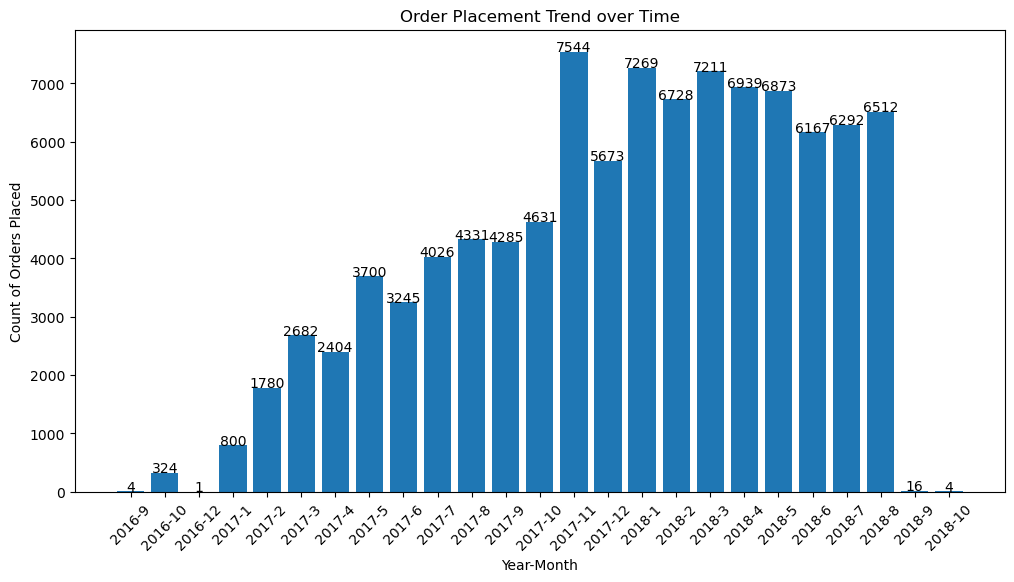

In [10]:
plt.figure(figsize=(12, 6))
plt.bar(range(len(growingTrendDF)), growingTrendDF['count_of_orders_placed'].to_numpy())

for i, count in enumerate(growingTrendDF['count_of_orders_placed'].to_numpy()):
    plt.text(i, count + 0.5, str(count), ha='center')

plt.xticks(range(len(growingTrendDF)), growingTrendDF['year_placed'].astype(str).to_numpy() + '-' + growingTrendDF['month_placed'].astype(str).to_numpy())

plt.xlabel('Year-Month')
plt.ylabel('Count of Orders Placed')
plt.title('Order Placement Trend over Time')

plt.xticks(rotation=45)

plt.show()

#### To see what period of time in a day more number of orders getting placed

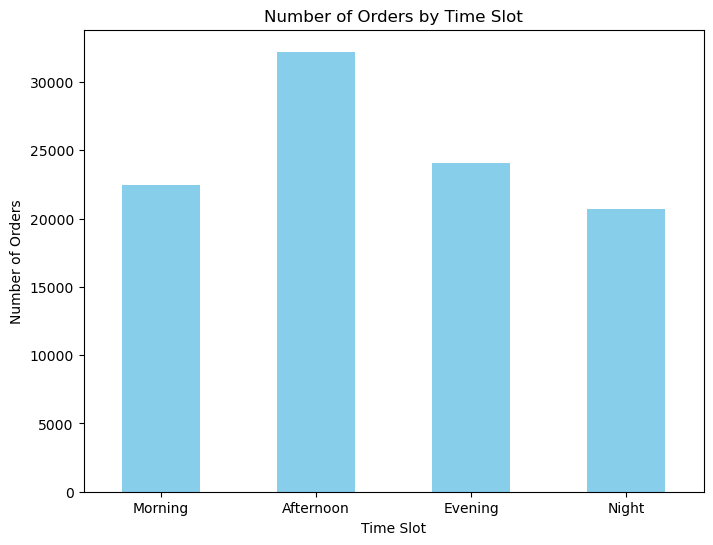

In [11]:
# Function to map hours to time slots
def categorize_time_slot(hour):
    if 5 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 21:
        return "Evening"
    else:
        return "Night"
# Extract the hour component from the 'order_purchase_timestamp' column
orders_data['order_hour'] = orders_data['order_purchase_timestamp'].dt.hour
# Apply the categorization function to create a new column 'time_slot'
orders_data['time_slot'] = orders_data['order_hour'].apply(categorize_time_slot)
# Now you have a 'time_slot' column in your DataFrame
time_slot_counts = orders_data['time_slot'].value_counts()
# Sort the counts by time slot order
time_slot_counts = time_slot_counts.reindex(["Morning", "Afternoon", "Evening", "Night"])
# Create a bar plot
plt.figure(figsize=(8, 6))
time_slot_counts.plot(kind='bar', color='skyblue')
plt.title("Number of Orders by Time Slot")
plt.xlabel("Time Slot")
plt.ylabel("Number of Orders")
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()


In [13]:


# Calculate the purchase_month, no_of_orders, and lagged_month columns
cte = (
    orders_data
    .merge(customers_data, on='customer_id', how='left')
    .groupby(['customer_state', orders_data['order_purchase_timestamp'].dt.month.rename('purchase_month')])
    .agg(no_of_orders=('order_id', 'count'))
    .reset_index()
)

cte['lagged_month'] = cte.groupby('customer_state')['purchase_month'].shift(1)

# Select the required columns
monthonmonthDF = cte[['purchase_month', 'customer_state', 'no_of_orders']]

# Sort the result
monthonmonthDF = monthonmonthDF.sort_values(by=['purchase_month', 'customer_state'], ascending=[True, True])

# Display the result (optional)
print(monthonmonthDF)

# Convert the original Spark SQL code for customercount to Pandas
# Calculate the count_of_customers by state
customercountDF = customers_data['customer_state'].value_counts().reset_index()
customercountDF.columns = ['customer_state', 'count_of_customers']

# Sort the result by count_of_customers column in descending order
customercountDF = customercountDF.sort_values(by='count_of_customers', ascending=False).head(50)

# Display the result (optional)
print(customercountDF)

# Create a bar chart to visualize


     purchase_month customer_state  no_of_orders
0                 1             AC             8
12                1             AL            39
24                1             AM            12
36                1             AP            11
48                1             BA           264
..              ...            ...           ...
273              12             RS           283
285              12             SC           193
297              12             SE            20
309              12             SP          2357
321              12             TO            14

[322 rows x 3 columns]
   customer_state  count_of_customers
0              SP               41746
1              RJ               12852
2              MG               11635
3              RS                5466
4              PR                5045
5              SC                3637
6              BA                3380
7              DF                2140
8              ES                2033
9       

#### Visualizing the customers state wide sales for top 50 states

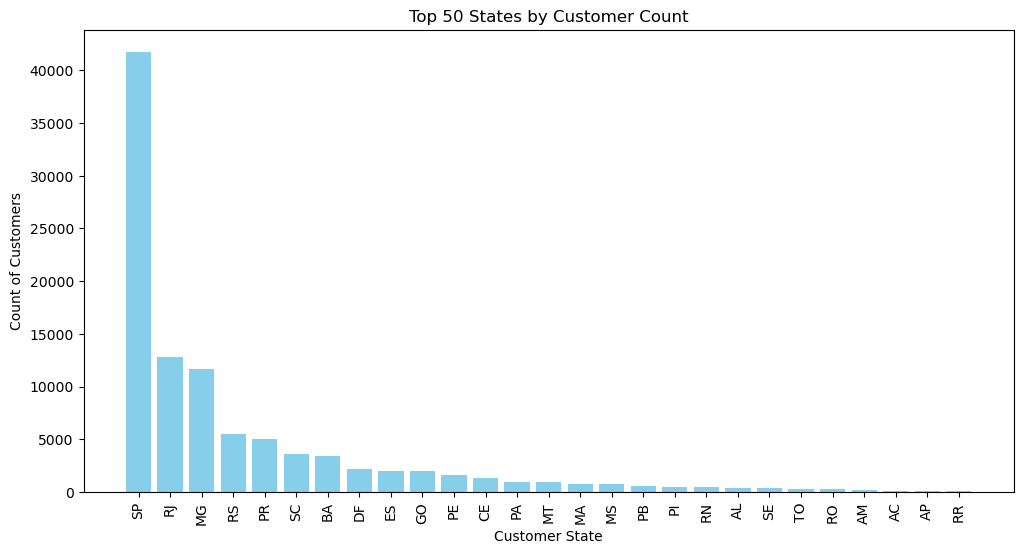

In [14]:
plt.figure(figsize=(12, 6))
plt.bar(customercountDF['customer_state'], customercountDF['count_of_customers'], color='skyblue')
plt.xlabel('Customer State')
plt.ylabel('Count of Customers')
plt.title('Top 50 States by Customer Count')
plt.xticks(rotation=90)
plt.show()

#### Total orders price for each state from the data 

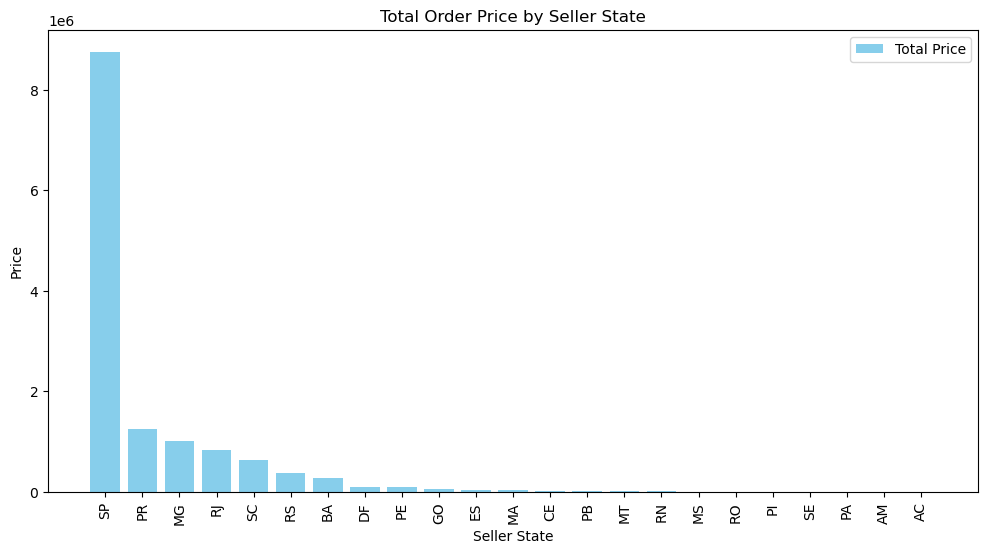

In [16]:

# Calculate the Total_Price and Average_Price for each state
data = (
    order_items_data
    .merge(sellers_data, on='seller_id', how='inner')
    .groupby('seller_state')
    .agg(Total_Price=('price', 'sum'), Average_Price=('price', 'mean'))
    .reset_index()
)

# Display the result (optional)
data.sort_values("Total_Price",ascending=False,inplace=True)


plt.figure(figsize=(12, 6))
plt.bar(data['seller_state'], data['Total_Price'], color='skyblue', label='Total Price')
# plt.bar(data['seller_state'], data['Average_Price'], color='lightcoral', label='Average Price')
plt.xlabel('Seller State')
plt.ylabel('Price')
plt.title('Total Order Price by Seller State')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [17]:
#Convert the product category names from portugues to english using the product_category_data dataframe
products_data = products_data.merge(product_category_data, on='product_category_name', how='left')
products_data.drop("product_category_name",inplace=True,axis=1)

In [18]:
products_data.head()

product_id  product_name_lenght  \
0  1e9e8ef04dbcff4541ed26657ea517e5                 40.0   
1  3aa071139cb16b67ca9e5dea641aaa2f                 44.0   
2  96bd76ec8810374ed1b65e291975717f                 46.0   
3  cef67bcfe19066a932b7673e239eb23d                 27.0   
4  9dc1a7de274444849c219cff195d0b71                 37.0   

   product_description_lenght  product_photos_qty  product_weight_g  \
0                       287.0                 1.0             225.0   
1                       276.0                 1.0            1000.0   
2                       250.0                 1.0             154.0   
3                       261.0                 1.0             371.0   
4                       402.0                 4.0             625.0   

   product_length_cm  product_height_cm  product_width_cm  \
0               16.0               10.0              14.0   
1               30.0               18.0              20.0   
2               18.0                9.0              15.0   
3               26.0                4.0              26.0   
4               20.0               17.0              13.0   

  product_category_name_english  
0                     perfumery  
1                           art  
2                sports_leisure  
3                          baby  
4                    housewares

#### Visulizing which category product made highest no of times orders placed

<BarContainer object of 10 artists>

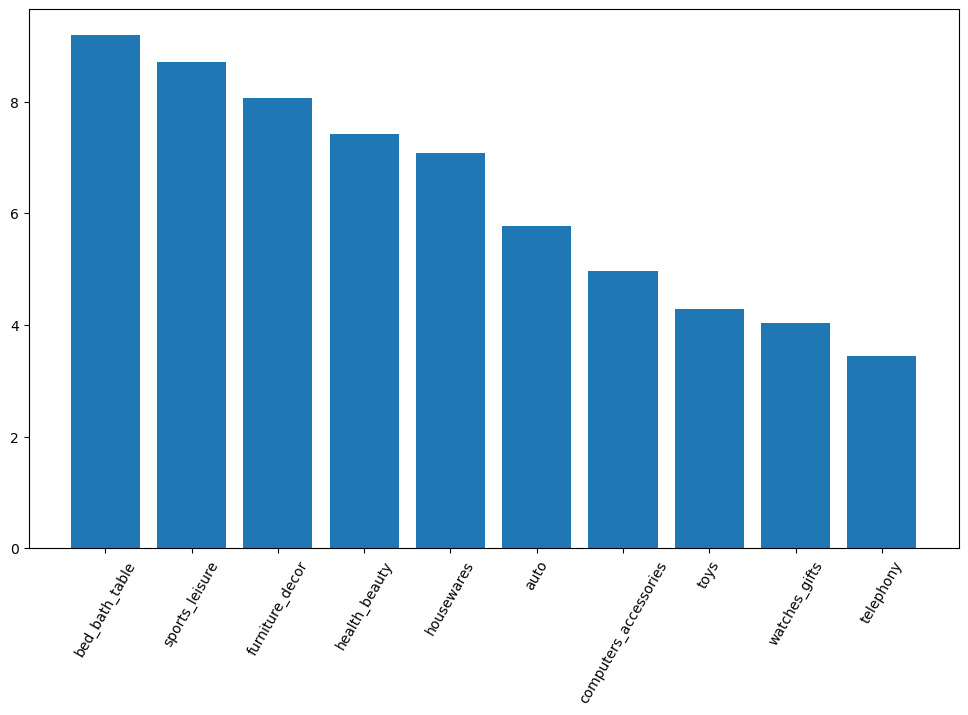

In [23]:
#Product category availability based on product dataset

value_counts=products_data["product_category_name_english"].value_counts()
percentages = (value_counts / len(products_data)) * 100
top_10=percentages.head(10)
plt.figure(figsize=(12,7))
plt.xticks(rotation=60)
plt.bar(top_10.to_dict().keys(), height=top_10.to_dict().values())

#### Percentage of orders delivered in time and exeded the time

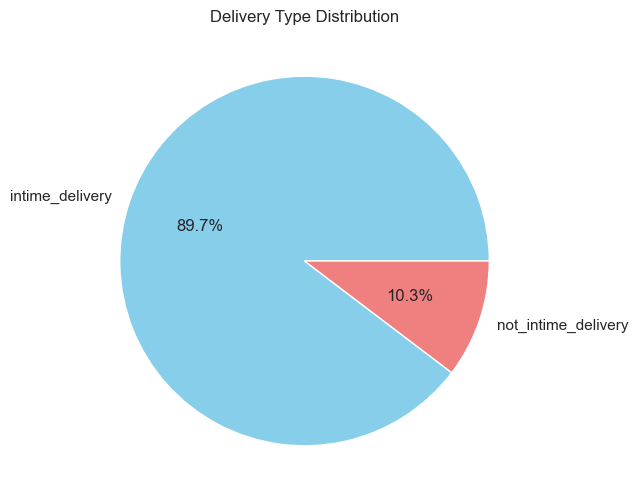

In [ ]:
date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                 'order_delivered_customer_date', 'order_estimated_delivery_date']

for col in date_columns:
    orders_data[col] = pd.to_datetime(orders_data[col])


orders_data['delivery_time'] = (orders_data['order_delivered_customer_date'] - orders_data['order_purchase_timestamp']).dt.days
orders_data['estimated_days'] = (orders_data['order_estimated_delivery_date'] - orders_data['order_purchase_timestamp']).dt.days
orders_data['delivery_type'] = ['intime_delivery' if days >= 0 else 'not_intime_delivery' for days in orders_data['estimated_days'] - orders_data['delivery_time']]


value_counts = orders_data['delivery_type'].value_counts()

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Delivery Type Distribution')
plt.show()

#### Top 5 States with highest freight value 

In [ ]:
import pandas as pd


# Calculate the top 5 states with the highest average freight value 
state_avg_freight = (
    order_items_data
    .merge(orders_data, on='order_id', how='inner')
    .merge(customers_data, on='customer_id', how='inner')
    .groupby('customer_state')
    .agg(avg_freight=('freight_value', 'mean'))
    .reset_index()
)

# Sort the result by 'avg_freight' in descending order
top5_states = state_avg_freight.sort_values(by='avg_freight', ascending=False).head(5)

# Display the result
print(top5_states)


   customer_state  avg_freight
21             RR    42.984423
14             PB    42.723804
20             RO    41.069712
0              AC    40.073370
16             PI    39.147970


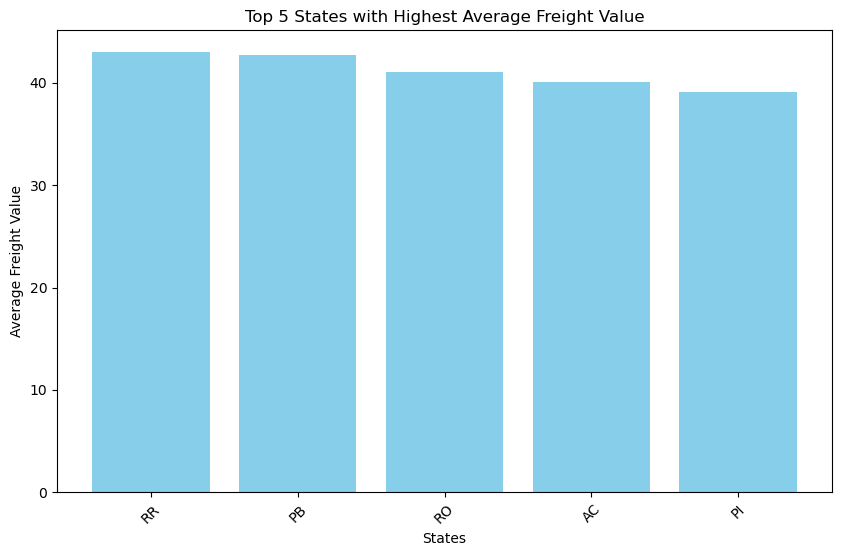

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(top5_states['customer_state'], top5_states['avg_freight'], color='skyblue')
plt.xlabel('States')
plt.ylabel('Average Freight Value')
plt.title('Top 5 States with Highest Average Freight Value')
plt.xticks(rotation=45)
plt.show()

#### We can see relation between no of orders placed using different type of payment process in each month of the year

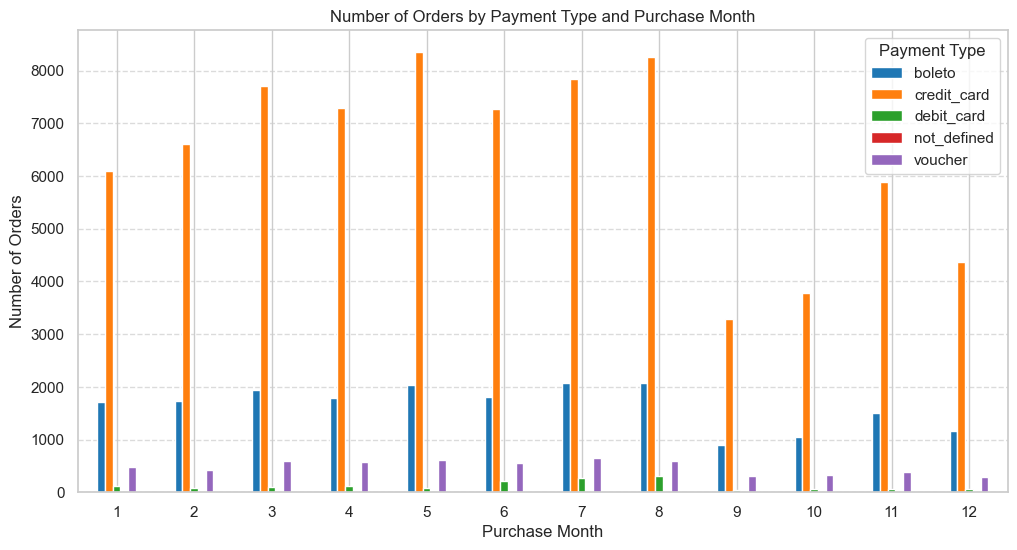

In [ ]:
cte = (
    orders_data
    .merge(order_payments_data, on='order_id', how='inner')
    .assign(purchase_month=lambda x: pd.to_datetime(x['order_purchase_timestamp']).dt.month)
    .groupby(['purchase_month', 'payment_type'])
    .agg(no_of_orders=('order_id', 'count'))
    .reset_index()
)

# Sort the result by 'payment_type' and 'no_of_orders' in ascending order
cte_sorted = cte.sort_values(by=['payment_type', 'no_of_orders'], ascending=[True, True])

# Pivot the data to create a clustered bar chart
pivot_df = cte_sorted.pivot(index='purchase_month', columns='payment_type', values='no_of_orders')

# Plot the clustered bar chart
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
ax = pivot_df.plot(kind='bar', stacked=False, color=colors, figsize=(12, 6))

# Customize the plot
plt.xlabel('Purchase Month')
plt.ylabel('Number of Orders')
plt.title('Number of Orders by Payment Type and Purchase Month')
plt.legend(title='Payment Type', loc='upper right')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

#### Visualizing the how many times different statuses of delivery happened

<BarContainer object of 8 artists>

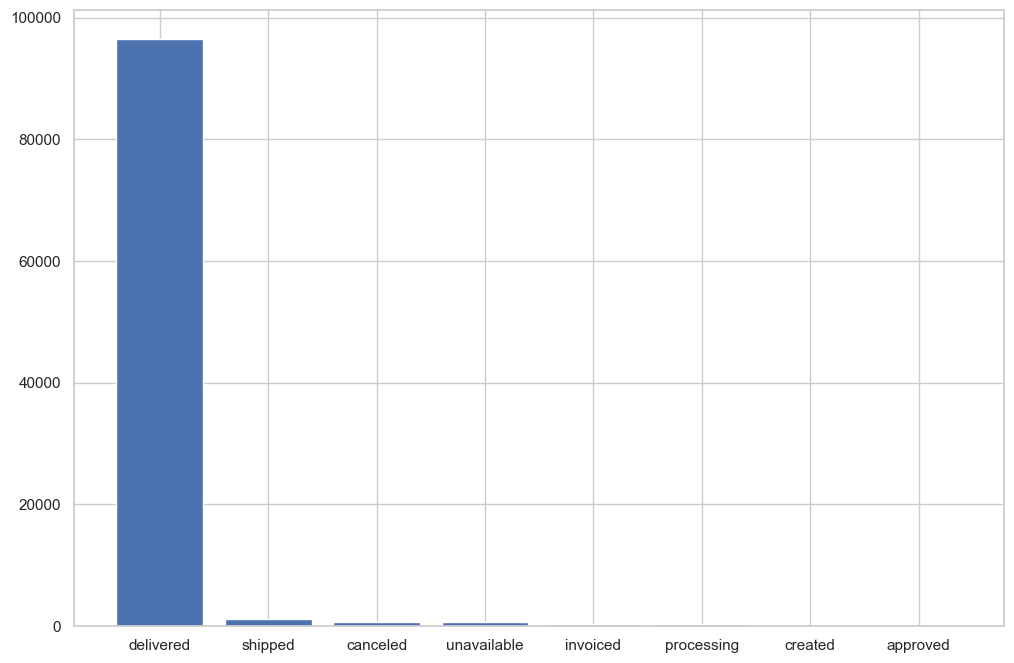

In [ ]:
cte = (
    orders_data
    .merge(customers_data, on='customer_id', how='inner')
    .groupby('order_status')
    .agg(count_of_customers=('customer_id', 'count'))
    .reset_index()
)

# Sort the result by 'count_of_customers' in descending order
statusDF = cte.sort_values(by='count_of_customers', ascending=False)

# Display the result
plt.figure(figsize=(12,8))
plt.bar(x=statusDF["order_status"],height=statusDF["count_of_customers"])

#### Number of Cities per Seller State

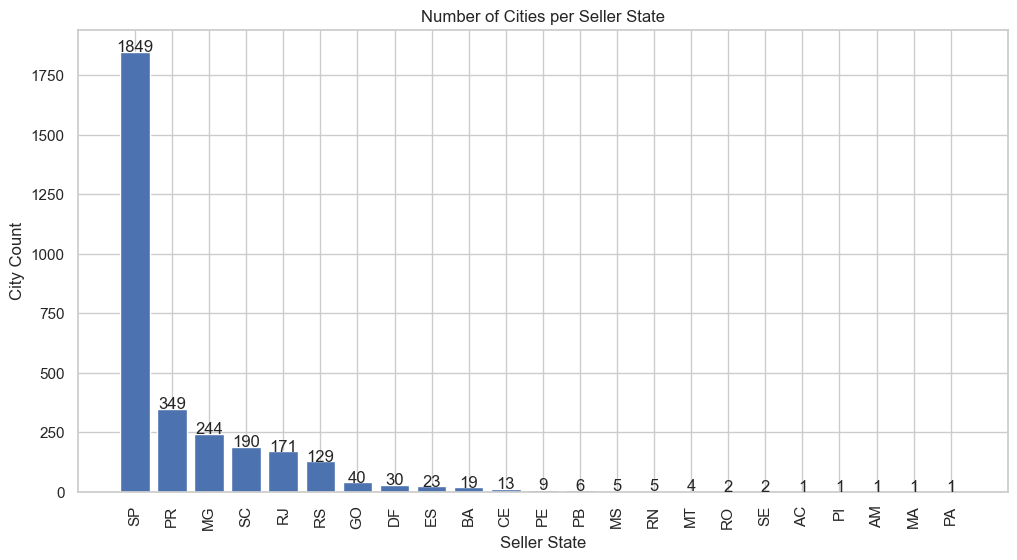

In [ ]:
seller_city_countDF = (
    sellers_data
    .groupby('seller_state')
    .agg(count_city=('seller_city', 'count'))
    .reset_index()
    .sort_values(by='count_city', ascending=False)
)

plt.figure(figsize=(12, 6))
plt.bar(seller_city_countDF['seller_state'].to_numpy(), seller_city_countDF['count_city'].to_numpy())

for i, count in enumerate(seller_city_countDF['count_city'].to_numpy()):
    plt.text(i, count + 0.5, str(count), ha='center')

plt.xlabel('Seller State')
plt.ylabel('City Count')
plt.title('Number of Cities per Seller State')
plt.xticks(rotation=90)
plt.show()


#### Count of orders for each review level

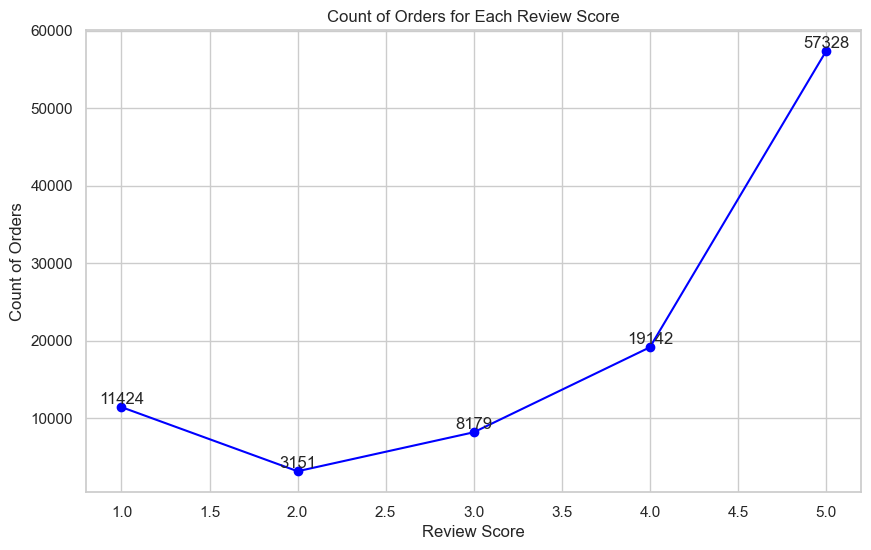

In [ ]:
scoreDF = (
    order_reviews_data
    .merge(orders_data, on='order_id', how='inner')
    .groupby('review_score')
    .agg(count_of_orders=('order_id', 'count'))
    .reset_index()
    .sort_values(by='review_score', ascending=True)
)

# Display the result
plt.figure(figsize=(10, 6))
line_color = "blue"
plt.plot(scoreDF['review_score'].to_numpy(), scoreDF['count_of_orders'].to_numpy(), marker='o', linestyle='-',color = line_color)

for x, y in zip(scoreDF['review_score'].to_numpy(), scoreDF['count_of_orders'].to_numpy()):
    plt.text(x, y, str(y), ha='center', va='bottom')

plt.xlabel('Review Score')
plt.ylabel('Count of Orders')
plt.title('Count of Orders for Each Review Score')

# Display the plot
plt.show()

In [27]:
#Calculating the churn predictions
for i ,j in data_dict.items():
    if "order_id" in list(j.columns):
       print(i) 


orders_data
order_items_data
order_payments_data
order_reviews_data


In [43]:
from prophet import Prophet


### Timeseriesmodel 

#### Segregating the useful information for the modelling 

In [44]:
orders_data['order_purchase_timestamp'] = pd.to_datetime(orders_data['order_purchase_timestamp'])
orders = orders_data[(orders_data['order_purchase_timestamp']>=pd.to_datetime('2017-01-01')) & (orders_data['order_purchase_timestamp']<=pd.to_datetime('2018-08-20'))]
orders = orders_data[['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp']]
orders = orders[orders['order_status'].isin(['shipped','delivered','invoiced'])]
orders['date'] = orders['order_purchase_timestamp'].dt.date

In [46]:
orders = orders.groupby('date').agg(total_orders=('order_id', 'nunique')).reset_index()
orders.head()

date  total_orders
0  2016-09-04             1
1  2016-09-15             1
2  2016-10-03             7
3  2016-10-04            58
4  2016-10-05            41

In [47]:
#Prepare the columns for days , months, years
orders['date'] = pd.to_datetime(orders['date'])
orders['dayofweek'] = orders['date'].dt.dayofweek
orders['quarter'] = orders['date'].dt.quarter
orders['month'] = orders['date'].dt.month
orders['year'] = orders['date'].dt.year
orders['dayofyear'] = orders['date'].dt.dayofyear
orders['dayofmonth'] = orders['date'].dt.day
orders['weekofyear'] = orders['date'].dt.weekofyear

C:\Users\leela\AppData\Local\Temp\ipykernel_7596\2606553907.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  orders['weekofyear'] = orders['date'].dt.weekofyear


#### We have seen there is a peak of orderes place in 2017-11-24 that was because of black friday sort of sale, this might not happen always so we will specify the holiday point to reduce the effect

In [50]:
import holidays

br_holidays = holidays.BR()
orders['events'] = orders['date'].apply(lambda x: br_holidays.get(x))

orders.loc[orders['date']==pd.to_datetime('2017-11-24'), 'events'] = 'black friday'

#### Visualizing the trend and diff holday points that includes our explicit holiday point

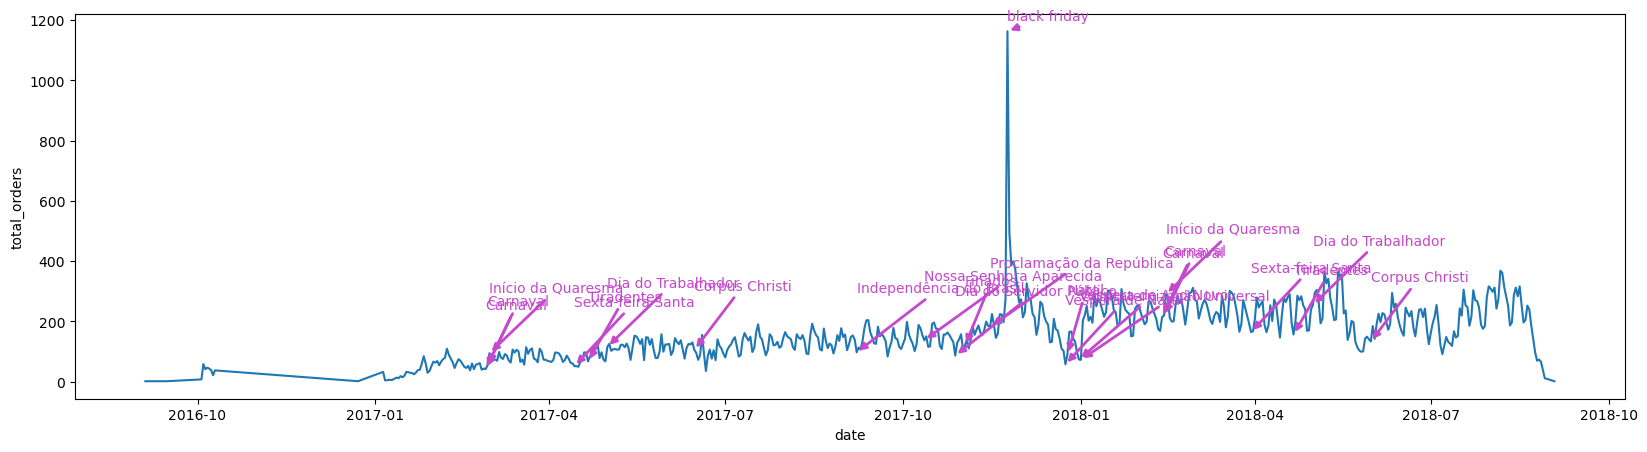

In [52]:
import seaborn as sns 

ann_color = '#c449cc' # annotation color
arrowprops=dict(arrowstyle='-|>', color=ann_color, linewidth=2)
plt.figure(figsize=(20,5))
sns.lineplot(data=orders, x='date', y='total_orders')

events = orders[orders['events'].notna()].to_dict('records')
for event in events:
    plt.annotate(event['events'], 
                xy=(event['date'], event['total_orders']), # arrow position (x, y)
                xytext=(event['date'], min(event['total_orders'] + 200, 1200)), # text position (x, y)
                fontsize=10,
                arrowprops=arrowprops,
                color=ann_color)

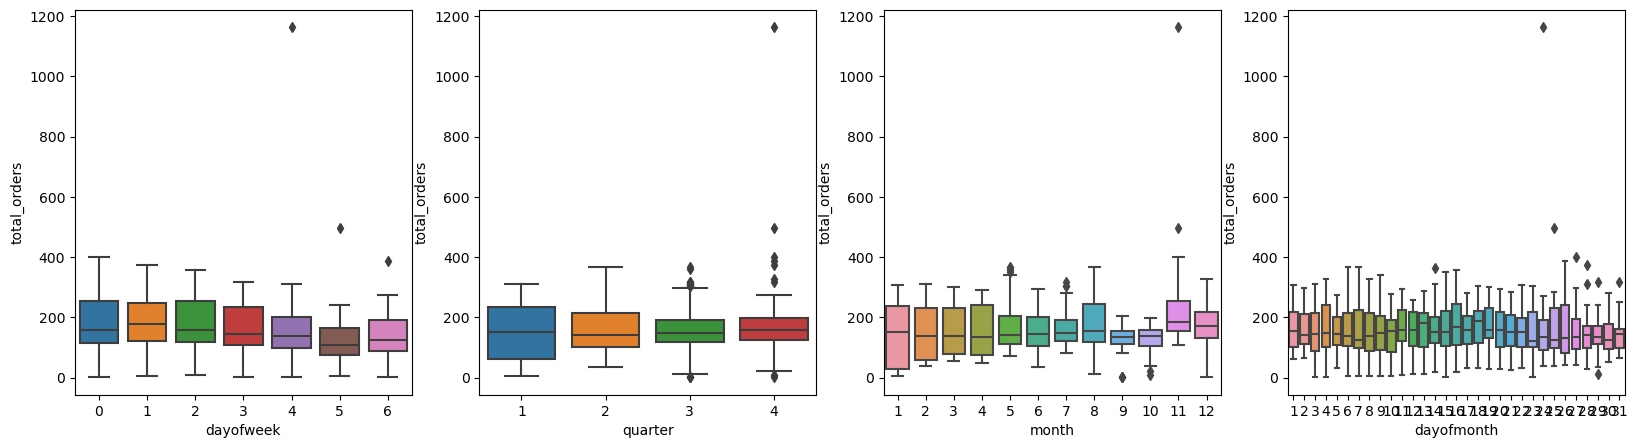

In [53]:
# There is a pattern in weekly sales, people tend to buy product on weekday instead of weekend, buy more in the middle and end of year, and buy less in the end of month

fig, ax = plt.subplots(1,4,figsize=(20,5))
for idx, col in enumerate(['dayofweek', 'quarter', 'month', 'dayofmonth']):
    sns.boxplot(data=orders, x=col, y='total_orders', ax=ax[idx])

#### Defining the train and test set and cosidering the useful information -dates , orders places

In [54]:
dates = orders['date'].sort_values().unique()
num_dates = len(dates)
dates_train = dates[:int(0.8*num_dates)]
dates_test = dates[int(0.8*num_dates):]
train = orders[orders['date'].isin(dates_train)]
test = orders[orders['date'].isin(dates_test)]

#### Applying scalling so that vales fall under the ranges between 0 to 1

In [57]:
scaler = MinMaxScaler()
scaler.fit(train[['total_orders']])
train['scaling'] = scaler.transform(train[['total_orders']])
test['scaling'] = scaler.transform(test[['total_orders']])

C:\Users\leela\AppData\Local\Temp\ipykernel_7596\2471818048.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['scaling'] = scaler.transform(train[['total_orders']])
C:\Users\leela\AppData\Local\Temp\ipykernel_7596\2471818048.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['scaling'] = scaler.transform(test[['total_orders']])


#### Treating the outliers using the winsorize method 

In [58]:
train['rmv_outliers'] = winsorize(train['scaling'], (0.01,0.009))

C:\Users\leela\AppData\Local\Temp\ipykernel_7596\602262428.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['rmv_outliers'] = winsorize(train['scaling'], (0.01,0.009))


In [59]:
winsorized_min, winsorized_max = train[train['rmv_outliers']!=train['scaling']]['rmv_outliers'].min(), train[train['rmv_outliers']!=train['scaling']]['rmv_outliers'].max()
winsorized_min, winsorized_max

(0.0025817555938037868, 0.32185886402753877)

#### NOw we are capping the winsorized_min, winsorized_max at records that cross top and bottom values 

In [60]:
test.loc[test['scaling']>winsorized_max, 'rmv_outliers'] = winsorized_max
test.loc[test['scaling']<winsorized_min, 'rmv_outliers'] = winsorized_min
test.loc[(test['scaling']>=winsorized_min)&(test['scaling']<=winsorized_max), 'rmv_outliers'] = test[(test['scaling']>=winsorized_min)&(test['scaling']<=winsorized_max)]['scaling']

C:\Users\leela\AppData\Local\Temp\ipykernel_7596\1080229728.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[test['scaling']>winsorized_max, 'rmv_outliers'] = winsorized_max


#### Display multiple visualizations for evaluating the performance of a predictive model

#### For each of the four specified columns ('dayofweek', 'quarter', 'month', 'dayofmonth'), it calculates the root mean squared error (RMSE) of the squared errors in the dataset when grouped by that column. Then, it creates a bar plot showing the RMSE values for each category within the column.


In [61]:
def plot_evaluation(dataset):
    fig, ax = plt.subplots(1,4,figsize=(20,5))
    for idx, col in enumerate(['dayofweek', 'quarter', 'month', 'dayofmonth']):
        plot_data = dataset.groupby(col)['squared_error'].mean().apply(np.sqrt).reset_index()
        sns.barplot(data=plot_data, x=col, y='squared_error', ax=ax[idx], color='orange')
        ax[idx].set_ylabel('RMSE')

    fig, ax = plt.subplots(1,2,figsize=(20,3))
    plot_data = dataset.groupby(['y','yhat'])['squared_error'].mean().apply(np.sqrt).reset_index()
    sns.scatterplot(data=plot_data, x='y', y='yhat', ax=ax[0], color='black')
    sns.scatterplot(data=plot_data, x='y', y='squared_error', ax=ax[1], color='black')
    ax[0].set_title("Correlation between actual and predicted sales")
    ax[0].set_xlabel('Actual Value')
    ax[0].set_ylabel('Predicted Value')
    ax[1].set_xlabel('Actual Value')
    ax[1].set_ylabel('RMSE')
    ax[1].set_title("Correlation between actual and RMSE")
    plt.show()

#### To create and display a time series plot that compares actual and predicted values over a specified time period.

#### Function generates a time series plot with two lines: one for predicted values (in orange) and another for actual values (in black)

In [62]:
def plot_time_series(dataset):
    plt.figure(figsize=(20,5))
    ax = sns.lineplot(x='ds', y='yhat', data=dataset, label='train predicted', color='orange')
    ax.fill_between(dataset['ds'], dataset['yhat_lower'], dataset['yhat_upper'], alpha=0.2)
    sns.lineplot(x='ds', y='y', data=dataset, label='train actual', color='black')
    plt.title("Time Series Plot Actual vs Predicted")
    plt.show()

#### Time series forecasting with Prophet 


#### If tuning is set to True, it performs hyperparameter tuning by evaluating different combinations of hyperparameters and selecting the best combination based on RMSE.

#### If the variant is 'scaling' or 'rmv_outliers', it inversely transforms the forecasted values and the original datasets to the original scale.
#### It calculates RMSE and visualizes the results for both the training and test datasets.

In [63]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

holidays = orders[orders['events'].notna()][['date','events']]
holidays[['lower_window', 'upper_window']] = [-7, 7]
holidays = holidays.rename(columns={'date':'ds','events':'holiday'})

def predict_eval(train, test, variant, tuning=False, holiday_context=False):
    dataset = train.copy()
    dataset_test = test.copy()
    col = {'date':'ds', variant:'y'}
    dataset = dataset.rename(columns=col)
    dataset_test = dataset_test.rename(columns=col)
    m = Prophet()
    
    if holiday_context:
        m = Prophet(holidays = holidays)
        m.add_country_holidays(country_name='BR')
    
    if tuning:
        # Generate all combinations of parameters
        all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
        rmses = []  # Store the RMSEs for each params here

        # Use cross validation to evaluate all parameters
        print("cross_validation")
        for params in tqdm(all_params):
            if holiday_context:
                m = Prophet(**params).fit(dataset)  # Fit model with given params
            else:
                m = Prophet(holidays=holidays, **params).fit(dataset)
            df_cv = cross_validation(model=m, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")
            df_p = performance_metrics(df_cv, rolling_window=1)
            rmses.append(df_p['rmse'].values[0])
        clear_output()
        best_params = all_params[np.argmin(rmses)]
        print(best_params)
        if holiday_context:
            m = Prophet(holidays=holidays, changepoint_prior_scale=best_params['changepoint_prior_scale'], seasonality_prior_scale=best_params['seasonality_prior_scale'], seasonality_mode=best_params['seasonality_mode'])
        else:
            m = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], seasonality_prior_scale=best_params['seasonality_prior_scale'], seasonality_mode=best_params['seasonality_mode'])

    m.fit(dataset)
    future = pd.DataFrame(dates_test, columns=['ds'])
    forecast = m.predict(future)
    forecast_today = m.predict(dataset)
    
    if variant in ['scaling', 'rmv_outliers']:
        forecast[['trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 
              'additive_terms', 'additive_terms_lower', 'additive_terms_upper','weekly', 
              'weekly_lower', 'weekly_upper', 'multiplicative_terms_upper', 'yhat']] = scaler.inverse_transform(
            forecast[['trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'additive_terms', 
                      'additive_terms_lower', 'additive_terms_upper','weekly', 'weekly_lower', 
                      'weekly_upper', 'multiplicative_terms_upper', 'yhat']])

        forecast_today[['trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 
              'additive_terms', 'additive_terms_lower', 'additive_terms_upper','weekly', 
              'weekly_lower', 'weekly_upper', 'multiplicative_terms_upper', 'yhat']] = scaler.inverse_transform(
            forecast_today[['trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'additive_terms', 
                            'additive_terms_lower', 'additive_terms_upper','weekly', 'weekly_lower', 
                            'weekly_upper', 'multiplicative_terms_upper', 'yhat']])
        dataset['y'] = scaler.inverse_transform(dataset[['y']])
        dataset_test['y'] = scaler.inverse_transform(dataset_test[['y']])

    forecast_today.index = dataset.index
    dataset[['yhat', 'yhat_lower', 'yhat_upper']] = forecast_today[['yhat', 'yhat_lower', 'yhat_upper']]
    dataset['squared_error'] = np.square(dataset['y'] - dataset['yhat'])

    print("Train dataset evaluation")
    print(f"RMSE: {np.sqrt(dataset['squared_error'].mean())}")
    plot_time_series(dataset)
    plot_evaluation(dataset)

    forecast.index = dataset_test.index
    dataset_test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]
    dataset_test['squared_error'] = np.square(dataset_test['y'] - dataset_test['yhat'])

    print("Test dataset evaluation")
    print(f"RMSE: {np.sqrt(dataset_test['squared_error'].mean())}")
    plot_time_series(dataset_test)
    plot_evaluation(dataset_test)

####  the code runs the time series forecasting model on the provided training and test datasets using the 'total_orders'

23:03:29 - cmdstanpy - INFO - Chain [1] start processing
23:03:30 - cmdstanpy - INFO - Chain [1] done processing


Train dataset evaluation
RMSE: 58.321999440347646


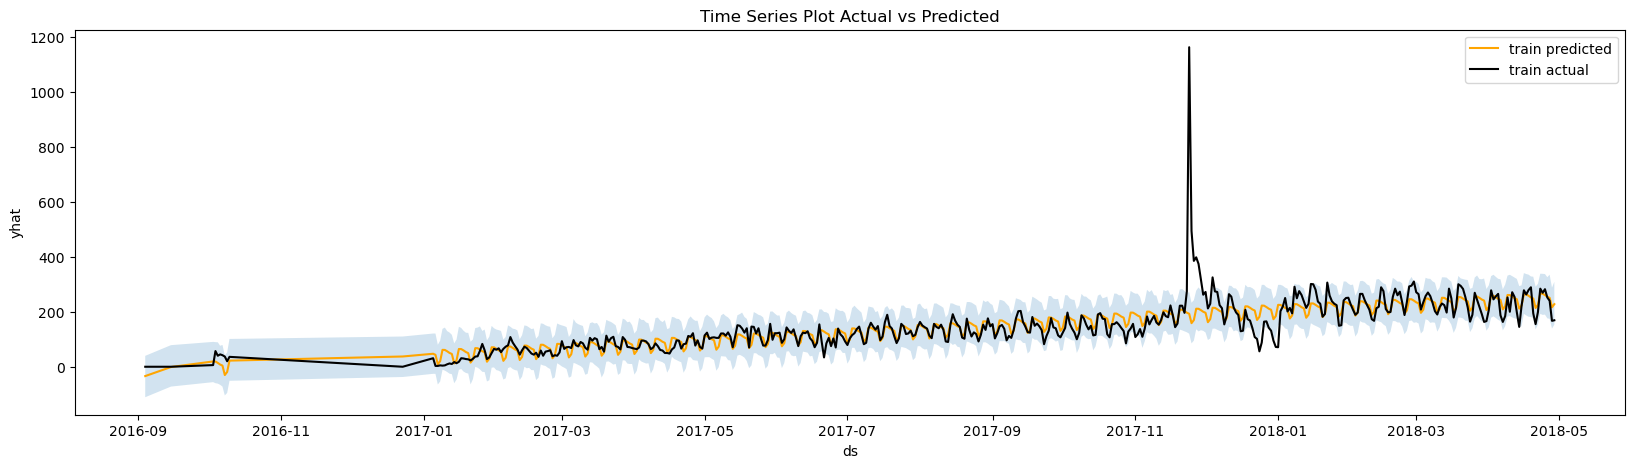

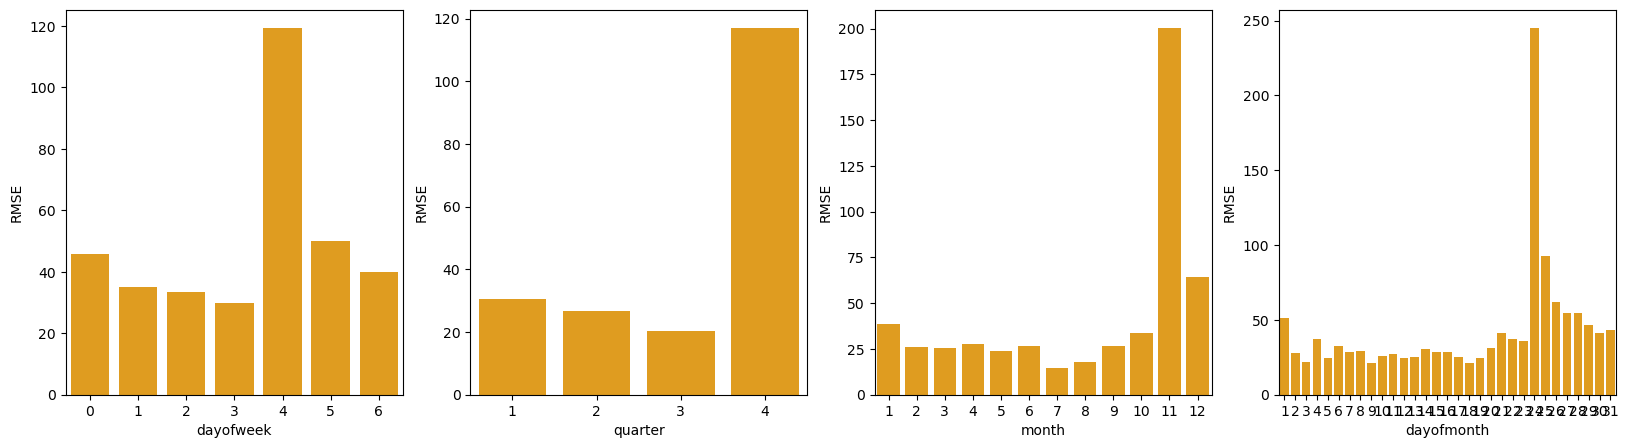

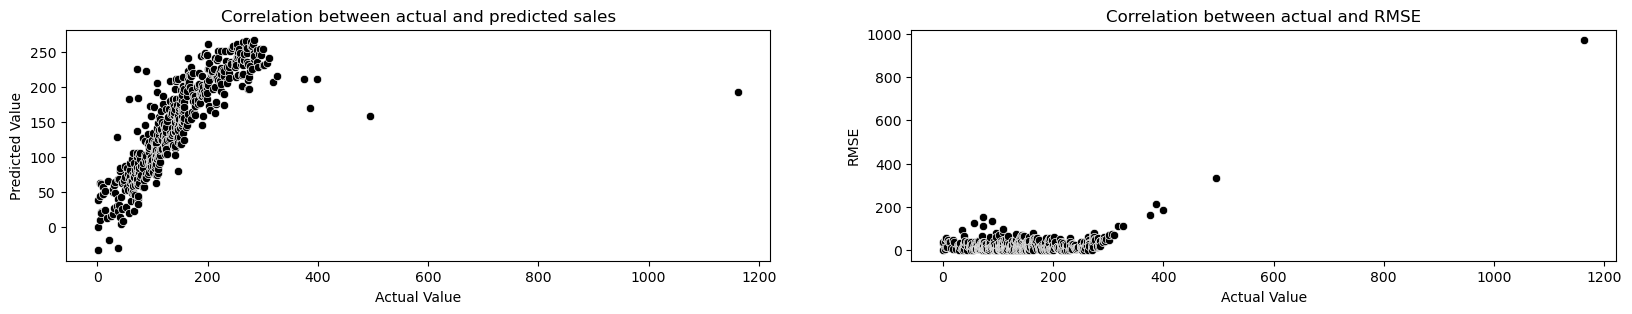

Test dataset evaluation
RMSE: 97.769502335669


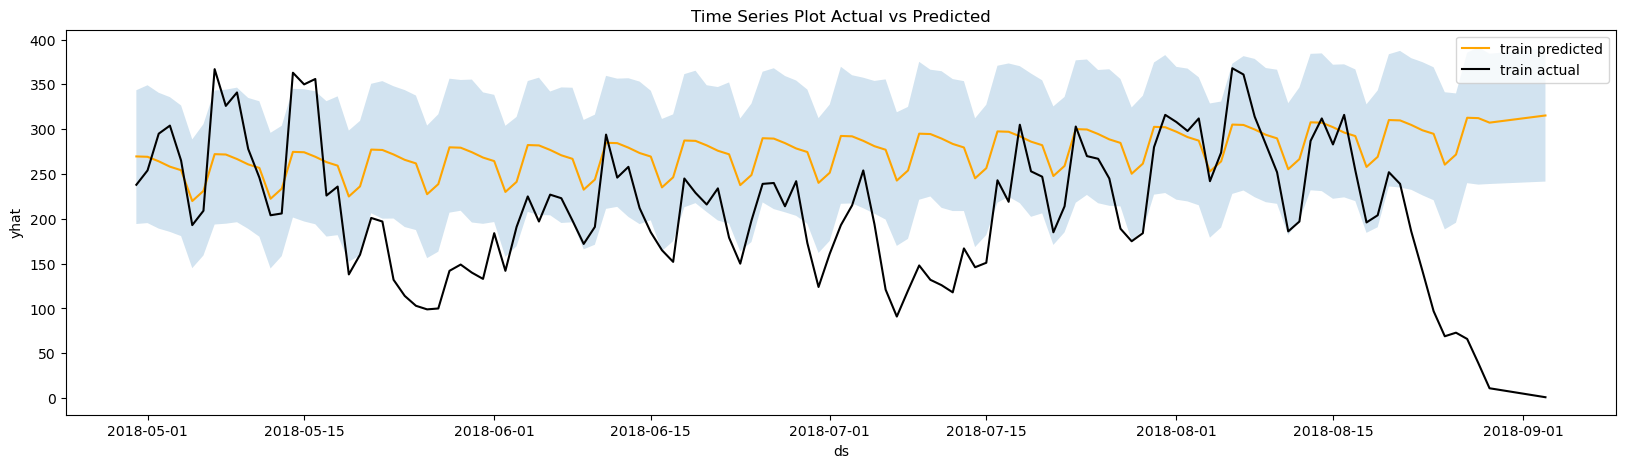

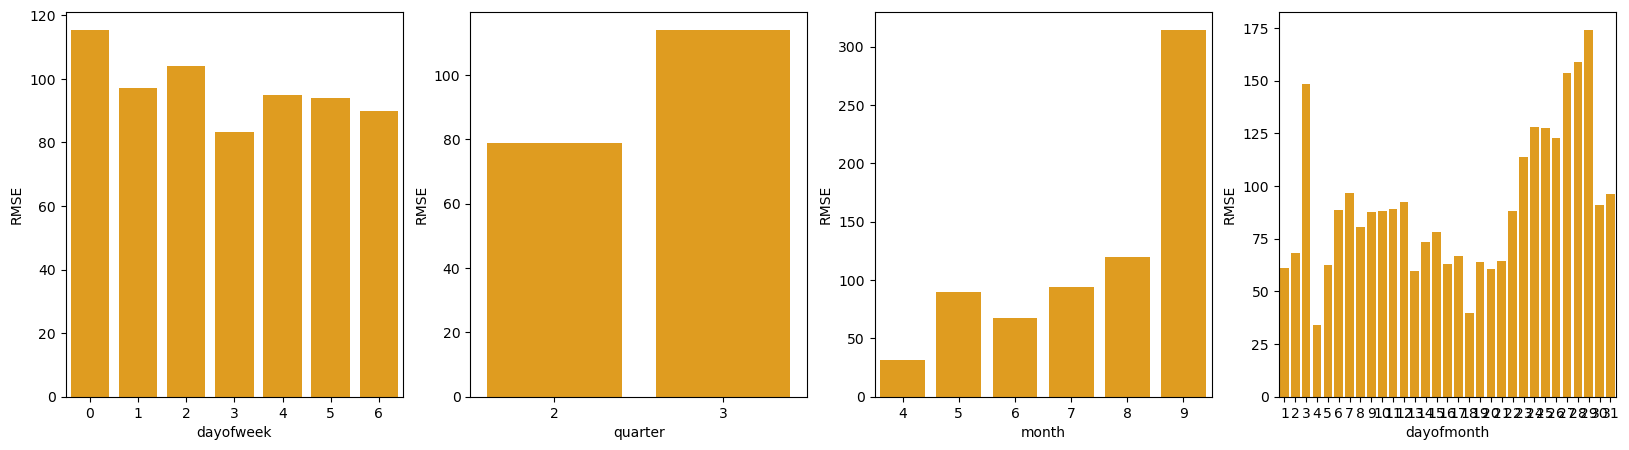

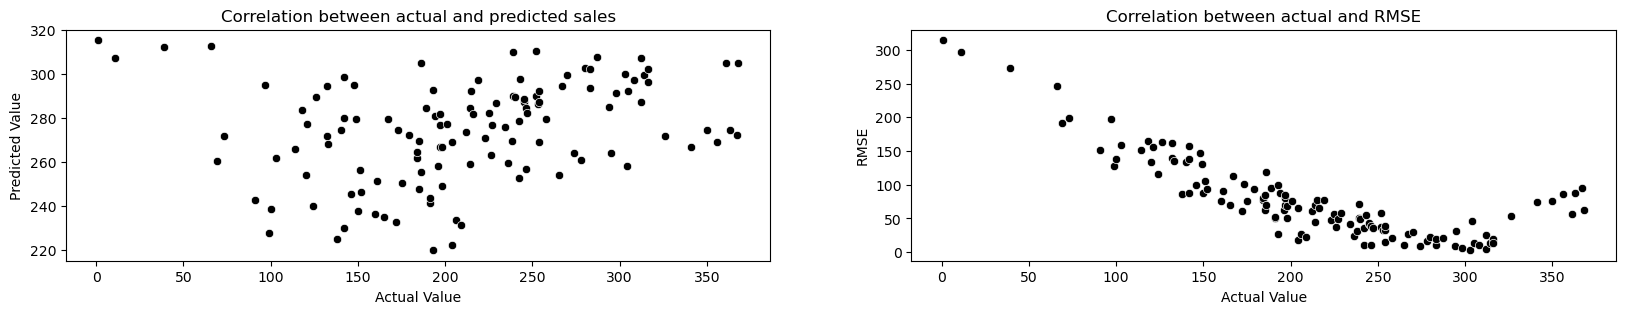

In [64]:
predict_eval(train, test, 'total_orders')

23:03:59 - cmdstanpy - INFO - Chain [1] start processing
23:03:59 - cmdstanpy - INFO - Chain [1] done processing


Train dataset evaluation
RMSE: 58.32193768415229


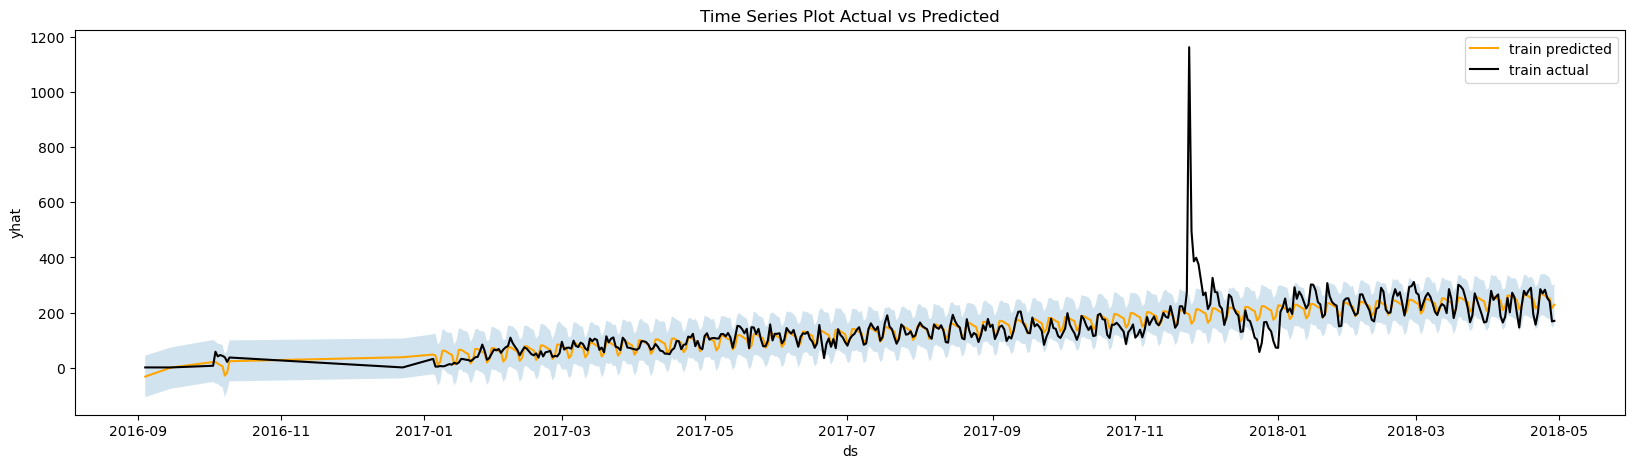

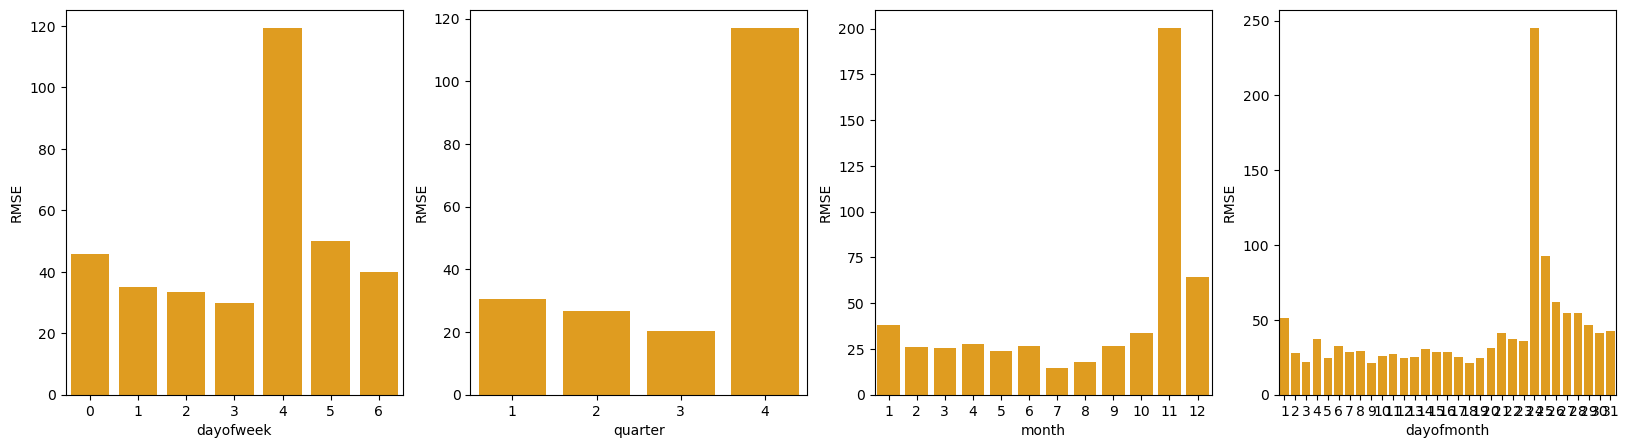

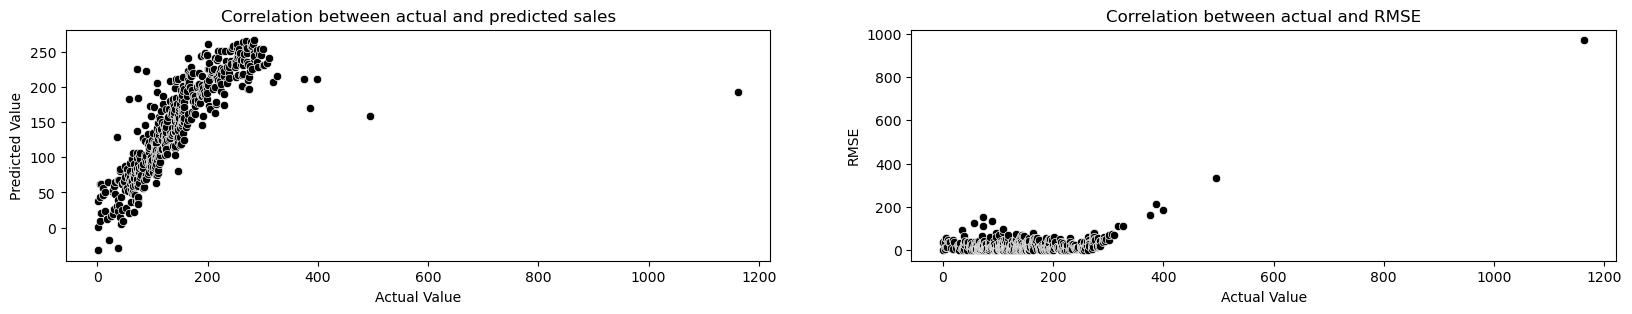

Test dataset evaluation
RMSE: 97.44311496763315


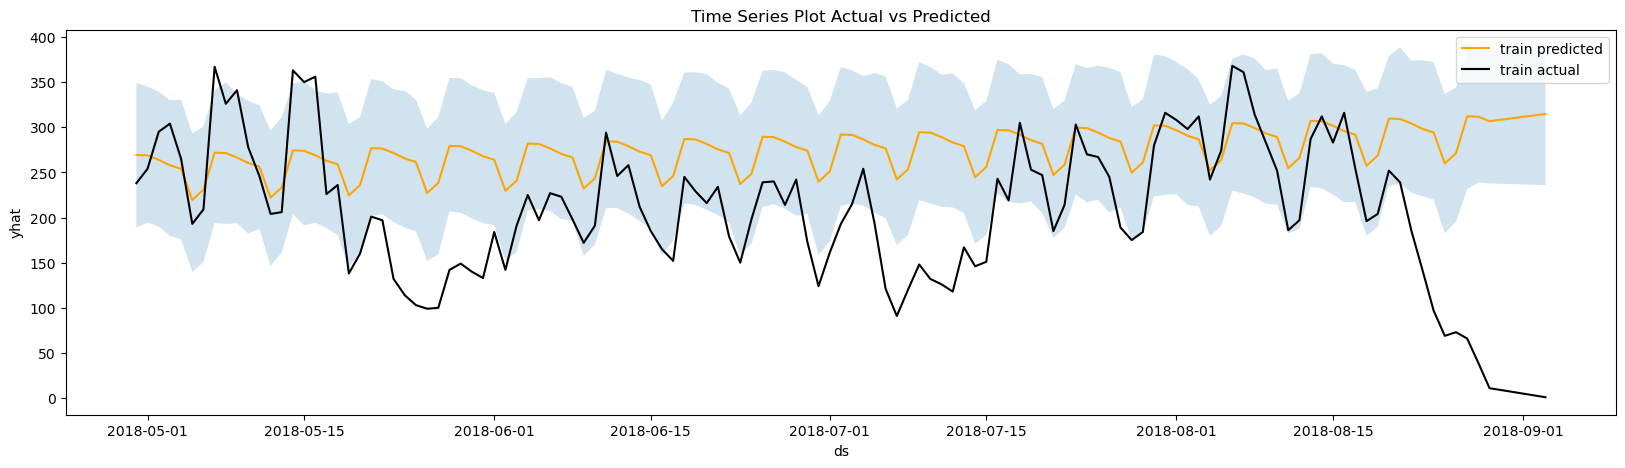

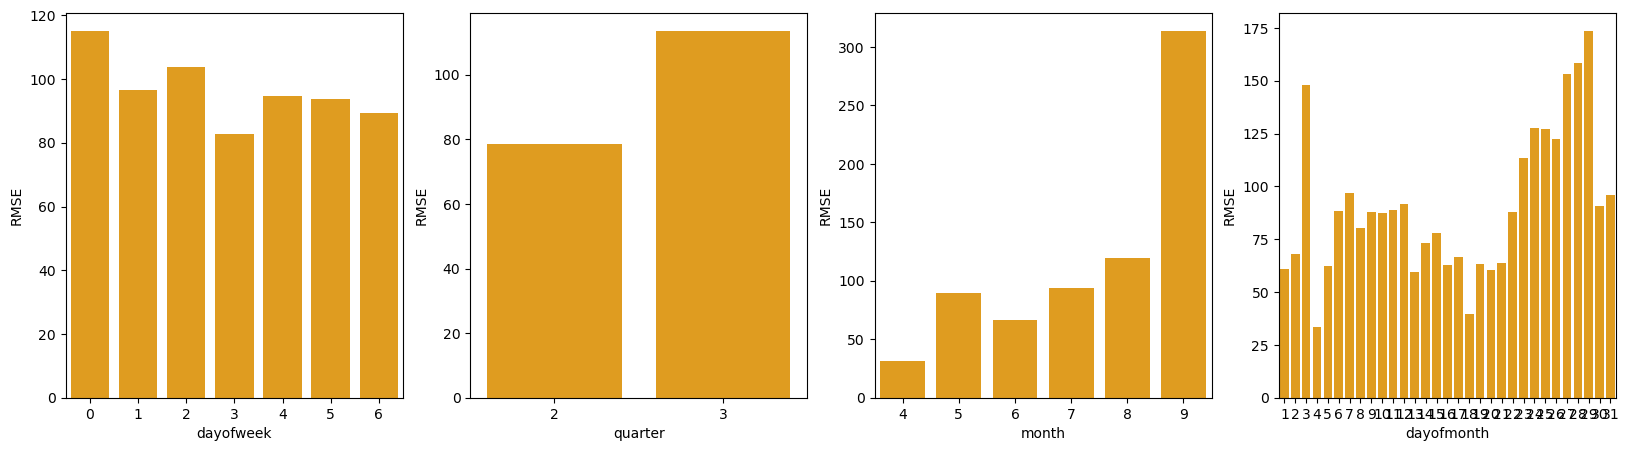

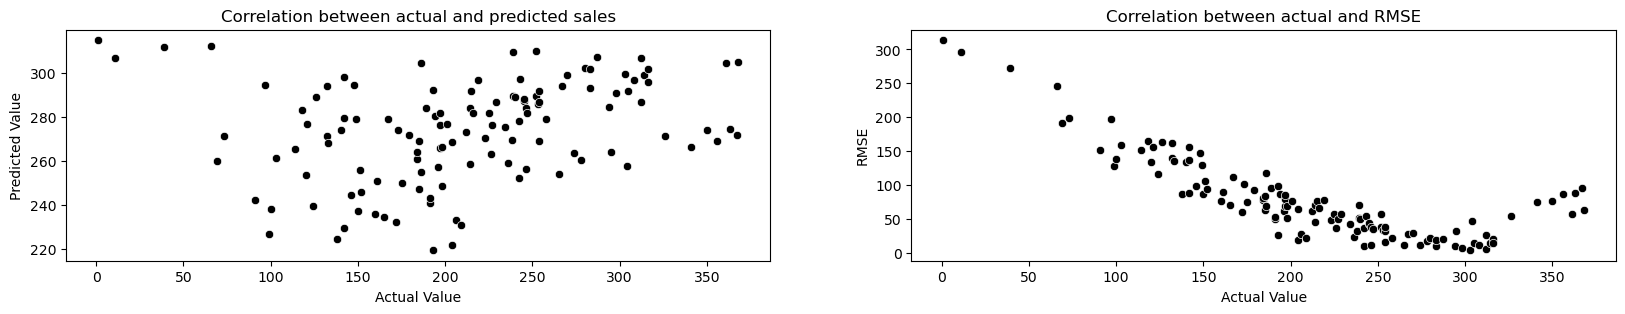

In [65]:
predict_eval(train, test, 'scaling')

 #### the code runs the time series forecasting model on the provided training and test datasets using the rmv_outliers

23:04:11 - cmdstanpy - INFO - Chain [1] start processing
23:04:11 - cmdstanpy - INFO - Chain [1] done processing


Train dataset evaluation
RMSE: 37.35261753741156


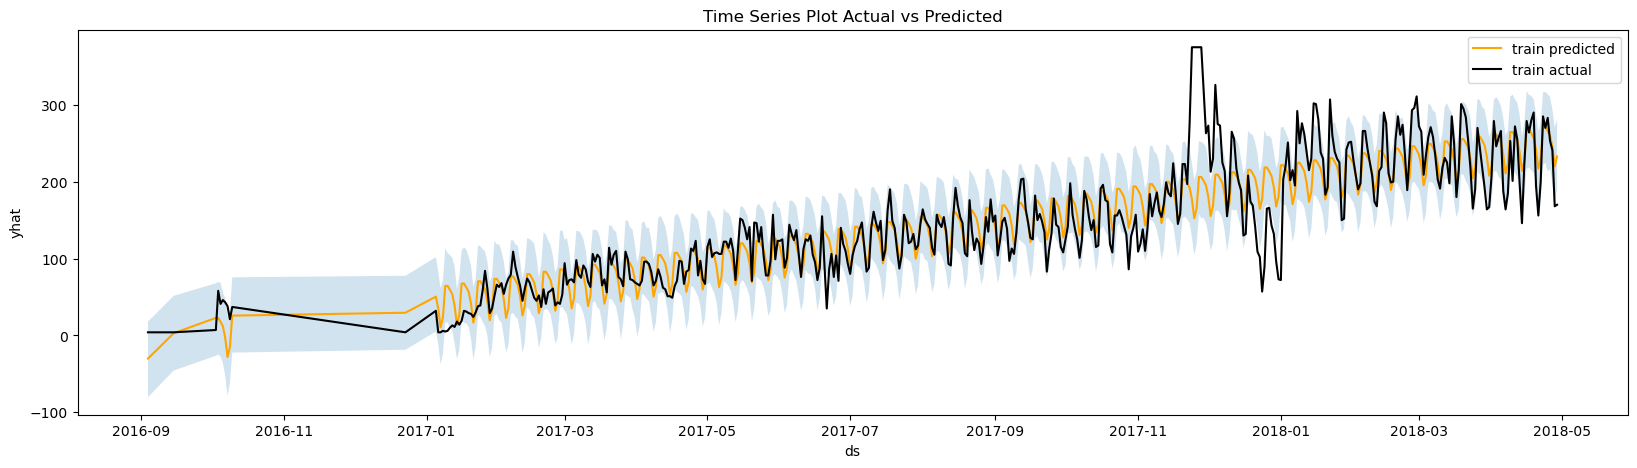

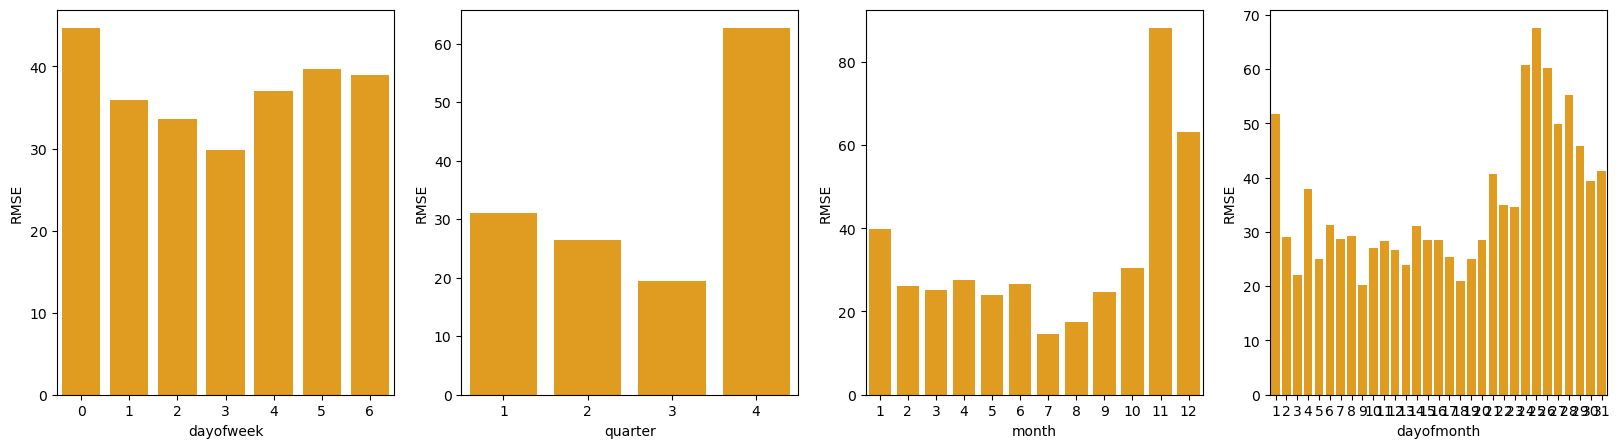

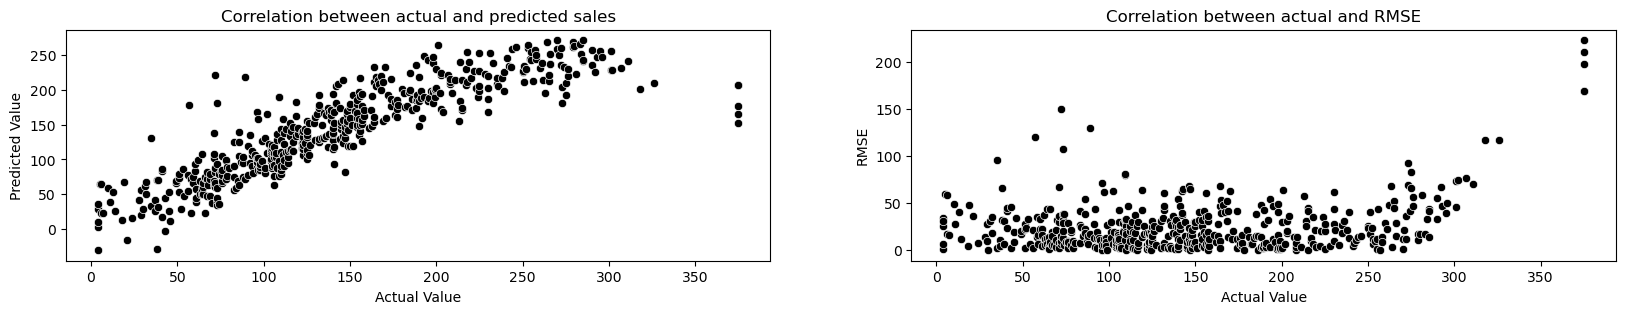

Test dataset evaluation
RMSE: 103.25258187758331


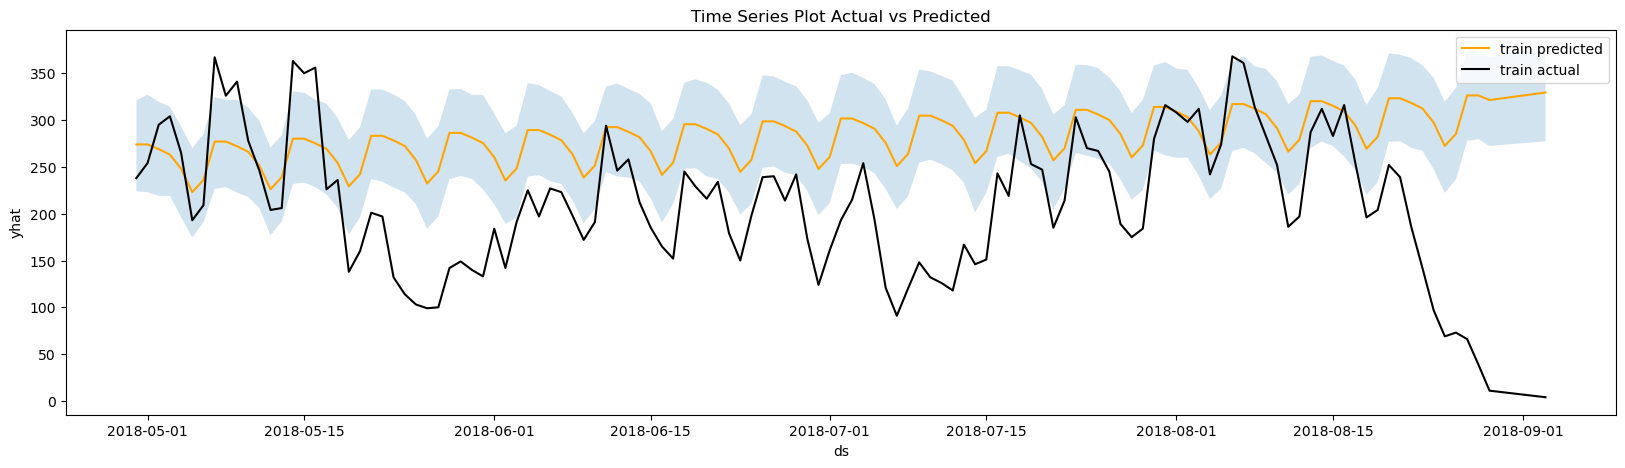

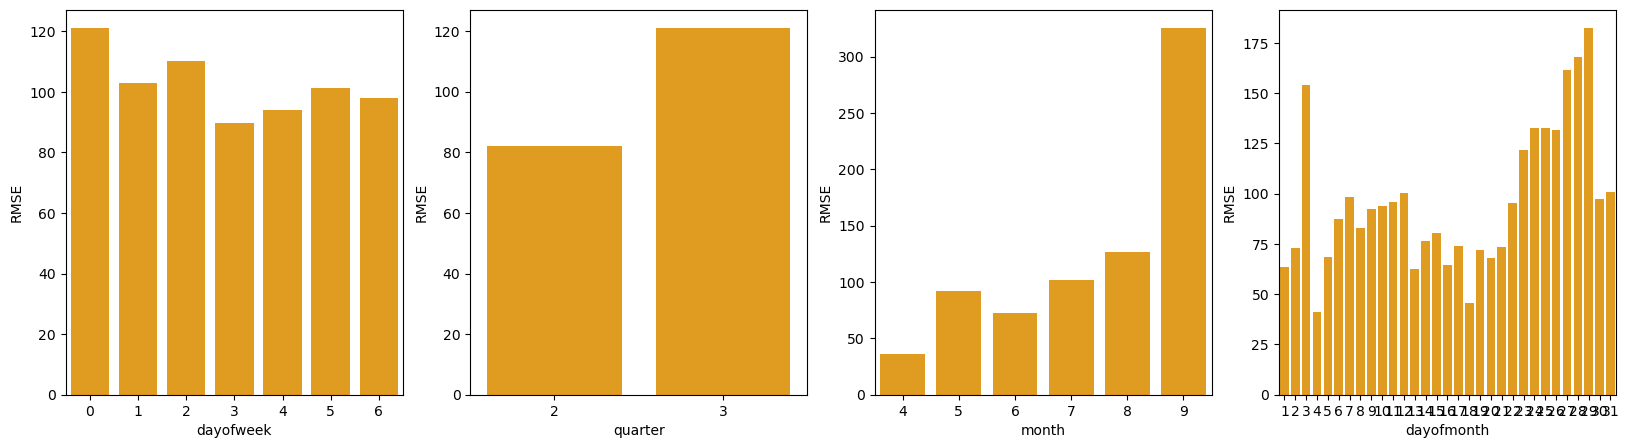

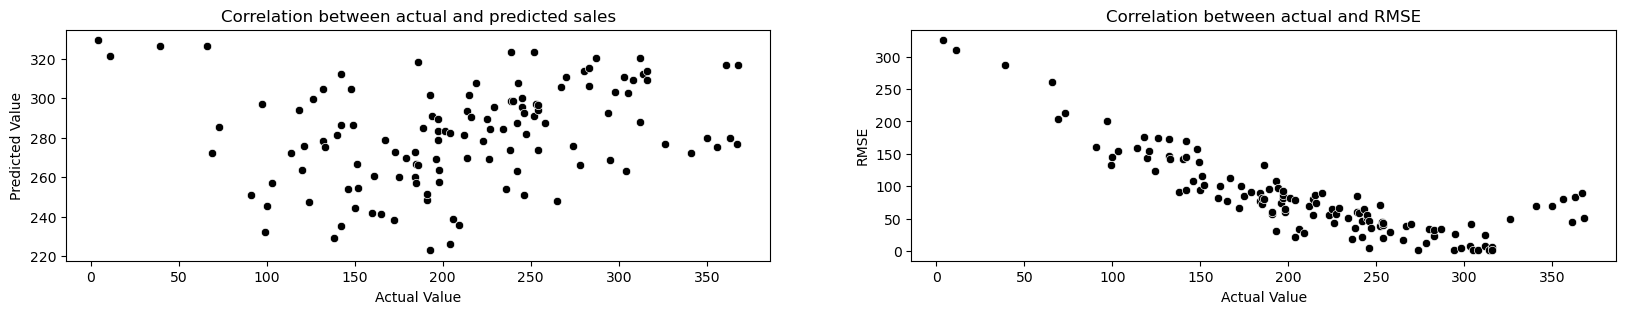

In [66]:
predict_eval(train, test, 'rmv_outliers')

### Using the hyperparamter tub=ning fing the low RMSE and best choice of parameters

## Hyperparameter tuning 

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


23:11:39 - cmdstanpy - INFO - Chain [1] start processing
23:11:39 - cmdstanpy - INFO - Chain [1] done processing


Train dataset evaluation
RMSE: 58.09357824791096


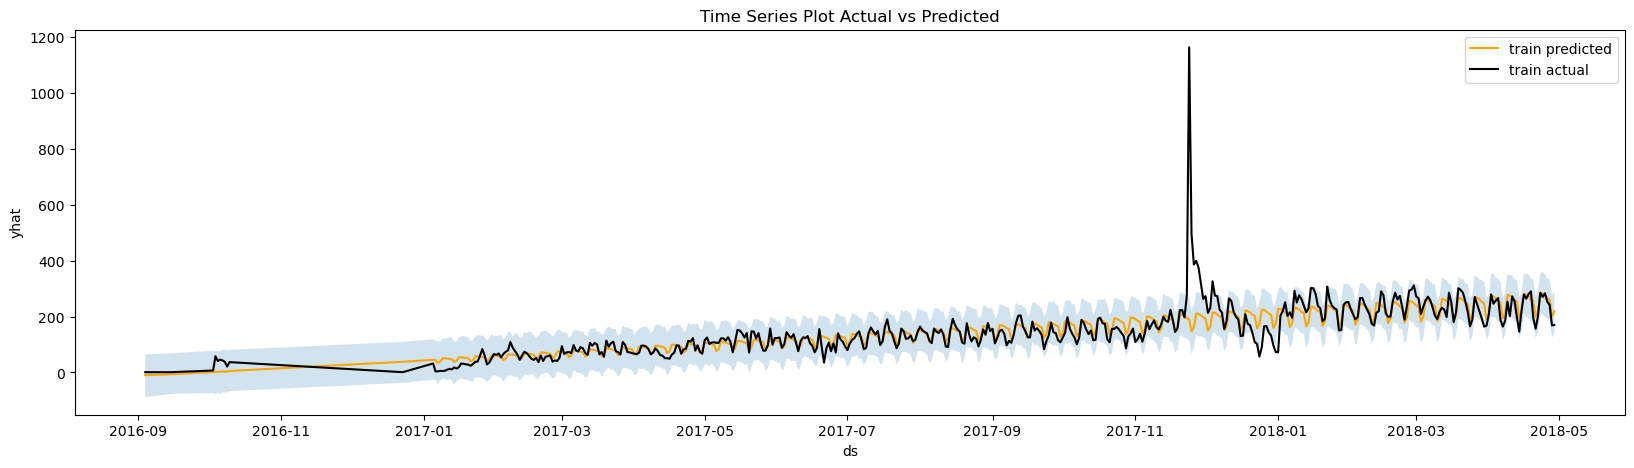

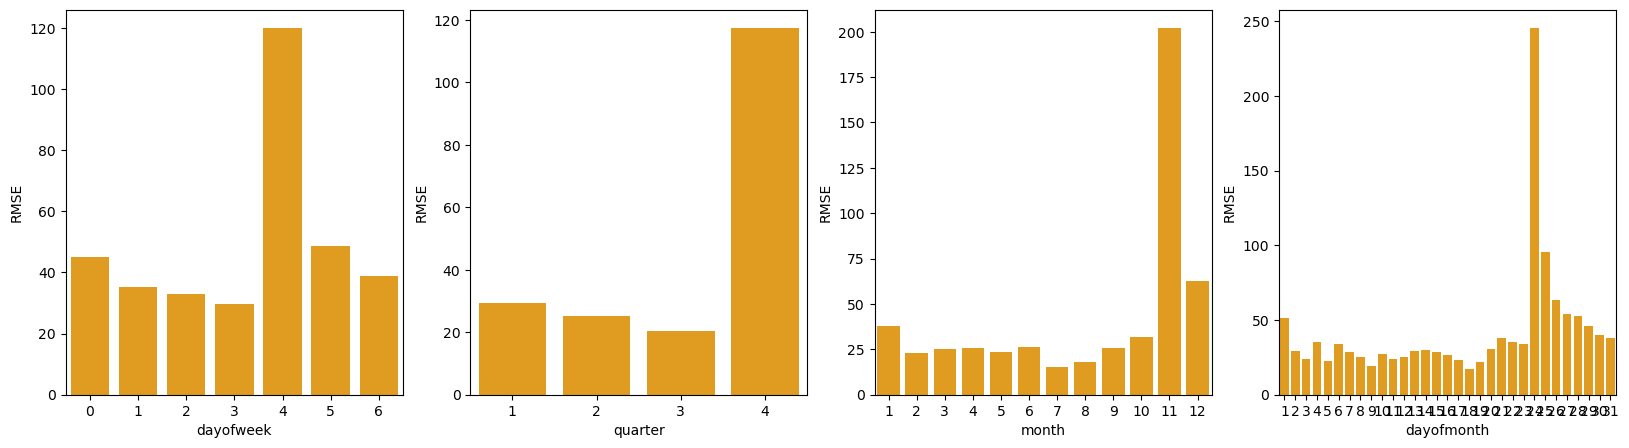

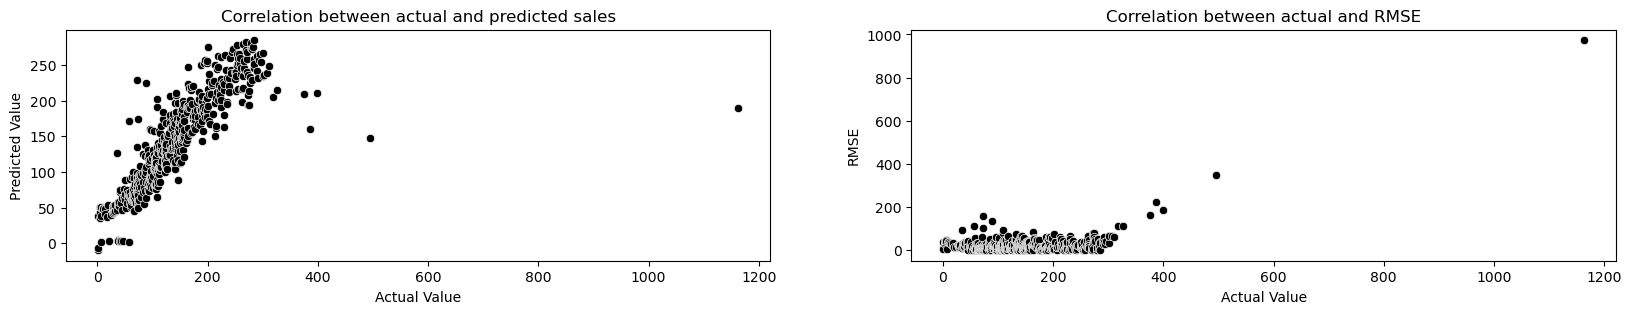

Test dataset evaluation
RMSE: 106.04252572925962


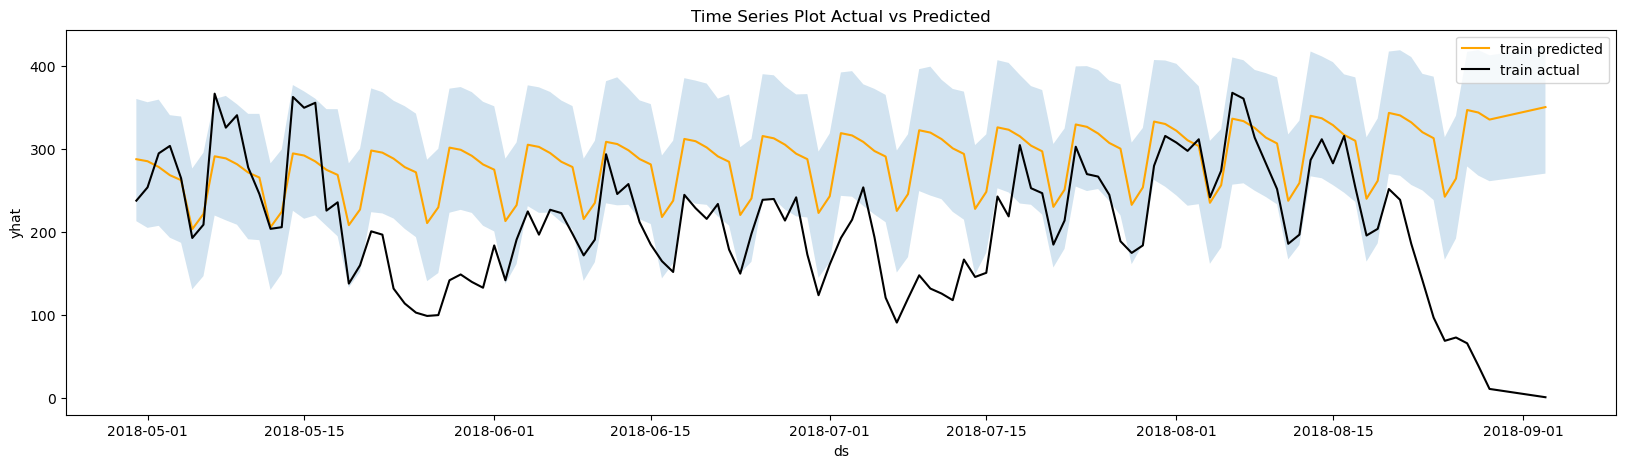

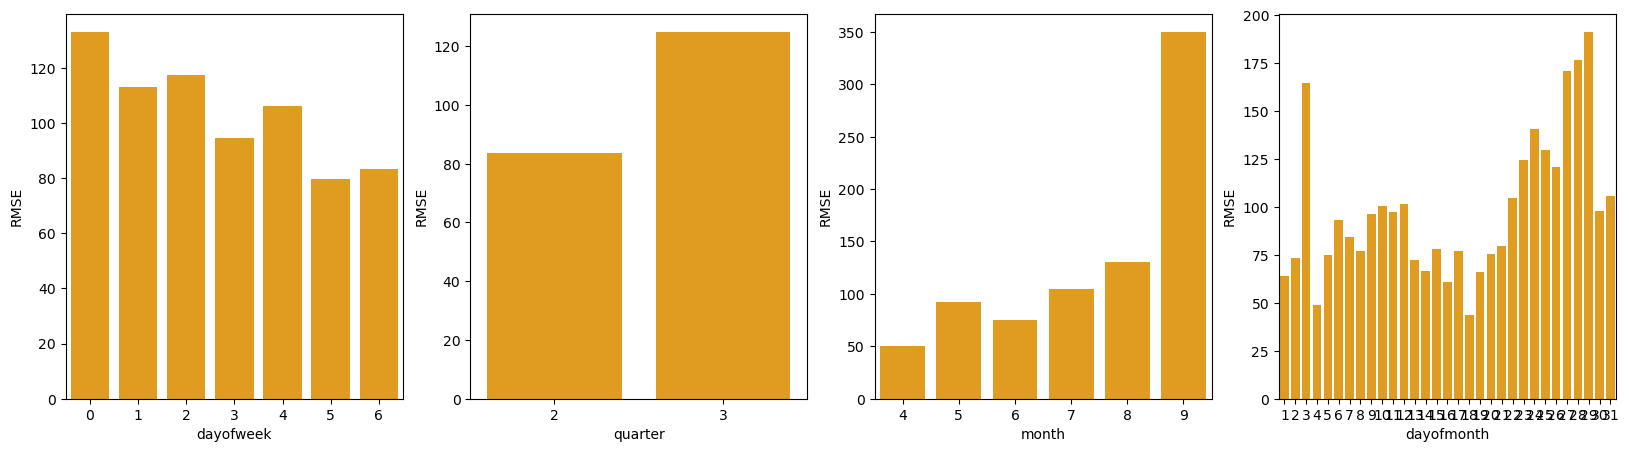

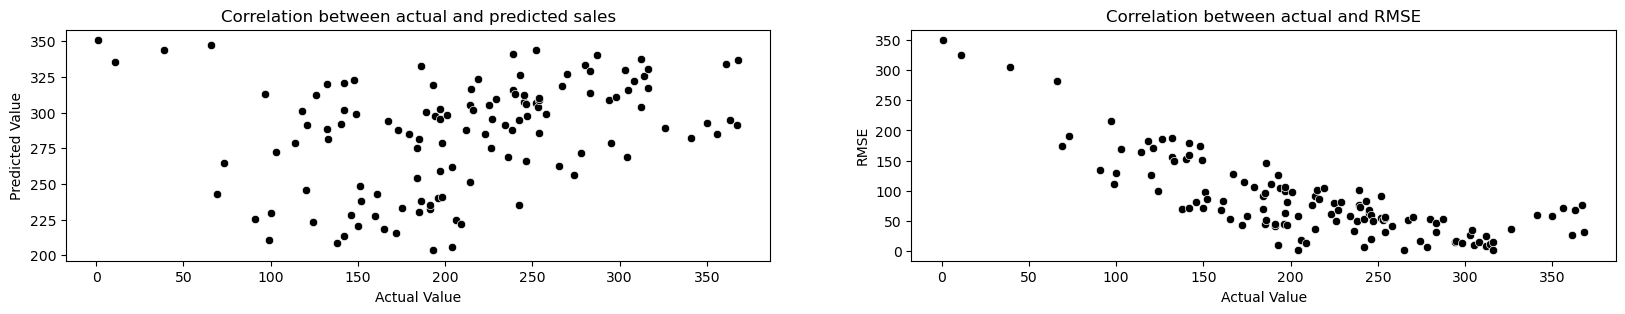

In [67]:
predict_eval(train, test, 'total_orders', tuning=True)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


23:21:16 - cmdstanpy - INFO - Chain [1] start processing
23:21:16 - cmdstanpy - INFO - Chain [1] done processing


Train dataset evaluation
RMSE: 58.10848148041992


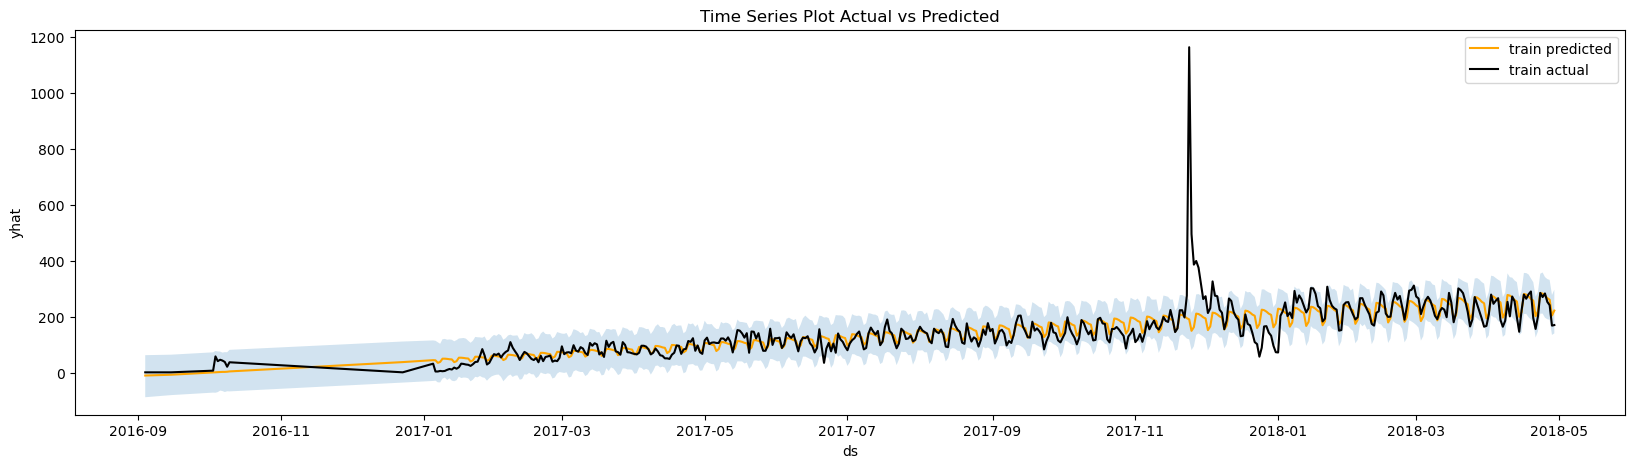

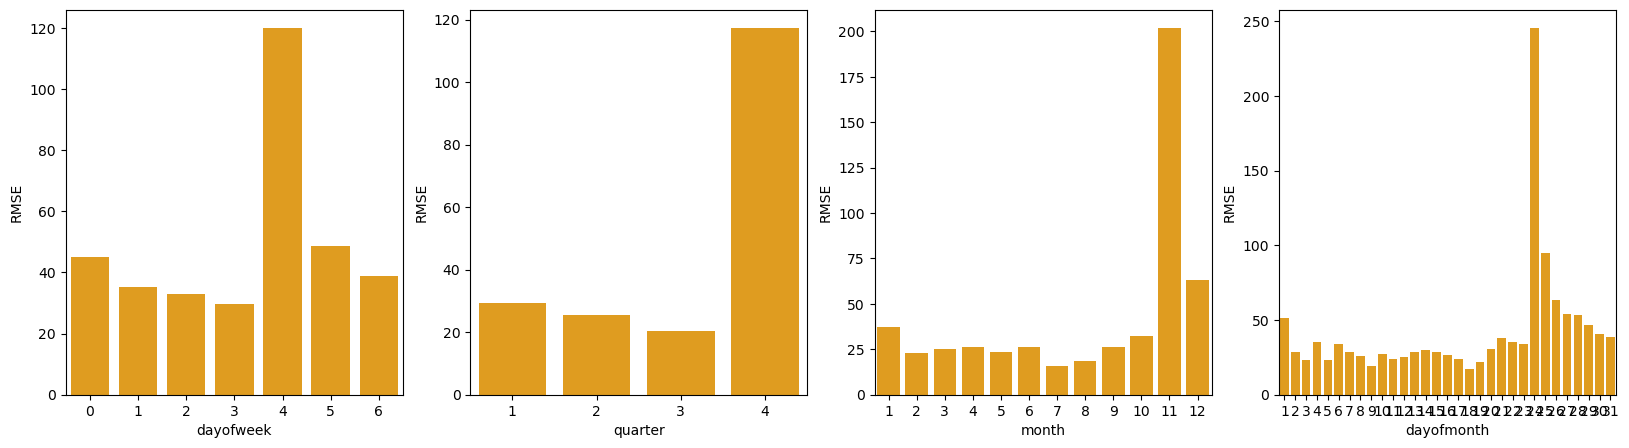

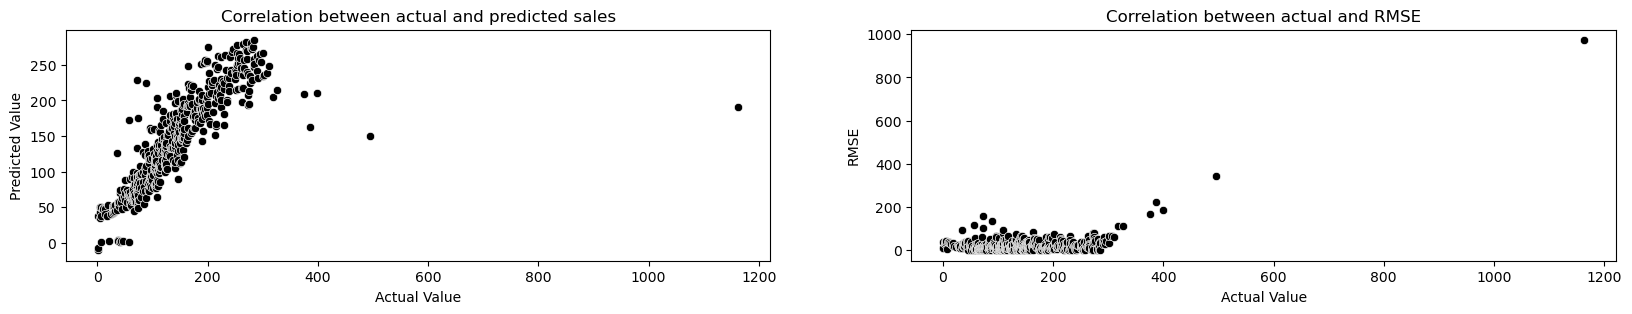

Test dataset evaluation
RMSE: 106.93765102480153


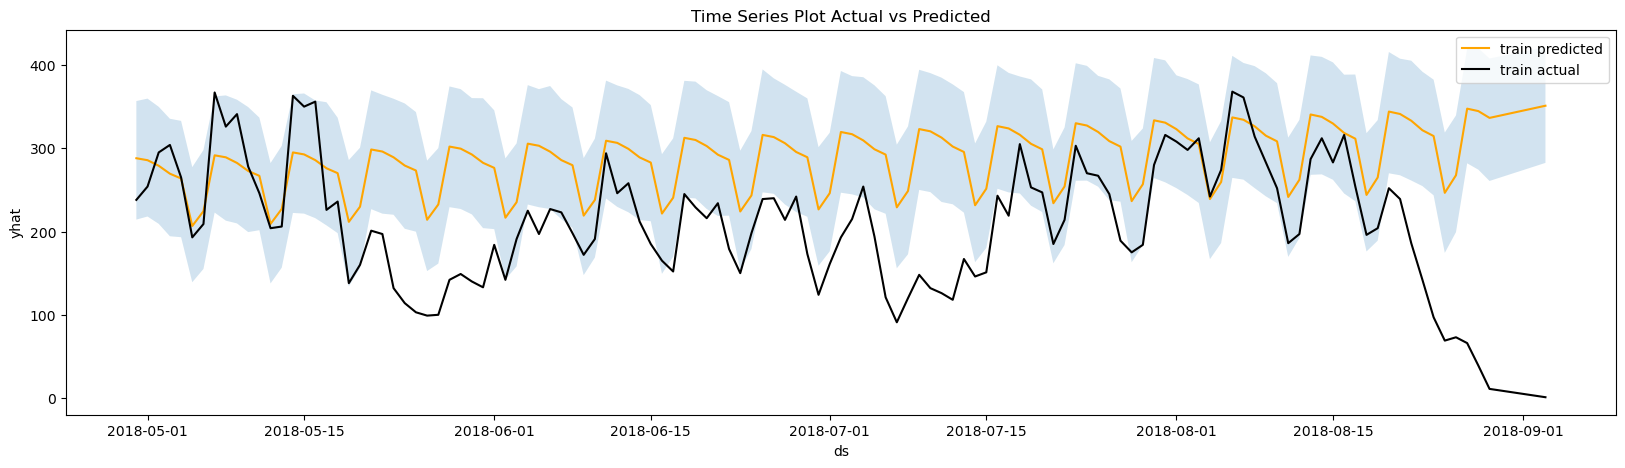

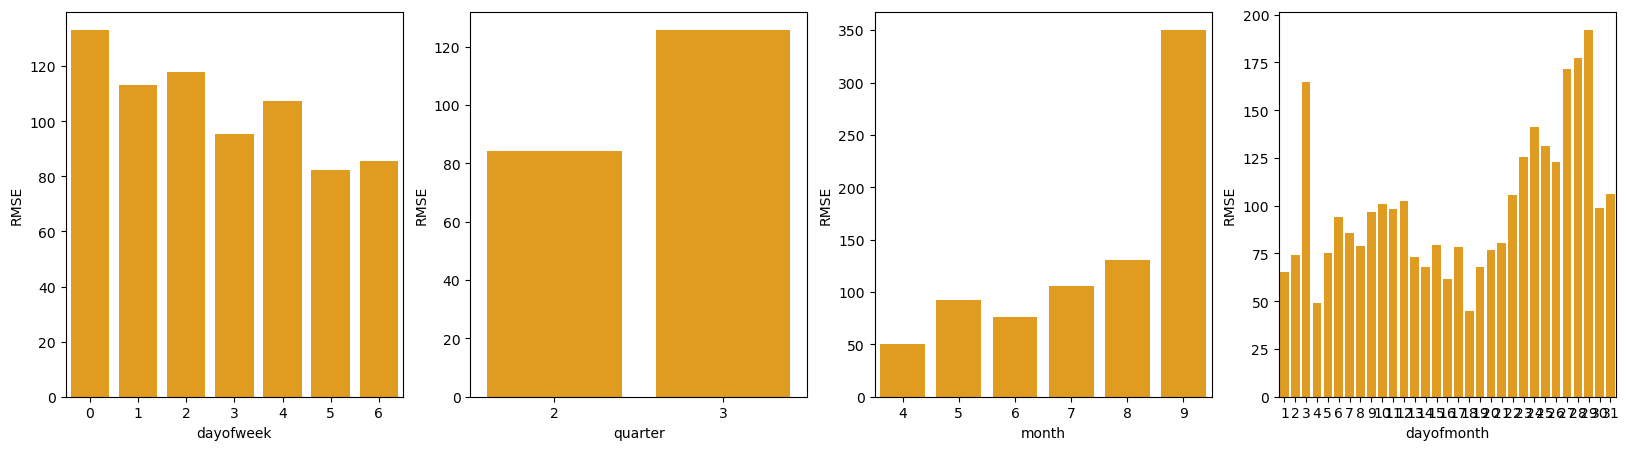

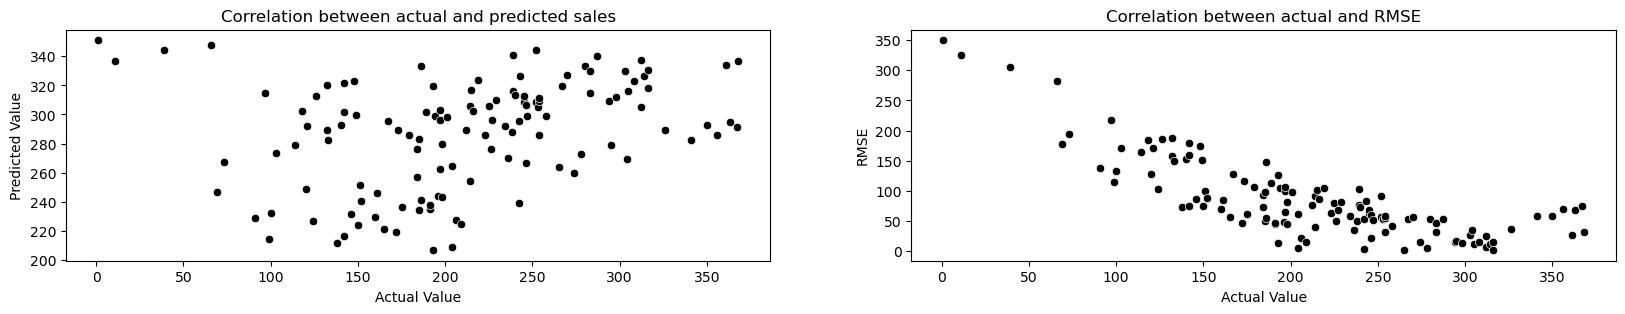

In [68]:
predict_eval(train, test, 'scaling', tuning=True)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


23:36:00 - cmdstanpy - INFO - Chain [1] start processing
23:36:00 - cmdstanpy - INFO - Chain [1] done processing


Train dataset evaluation
RMSE: 36.394974367868784


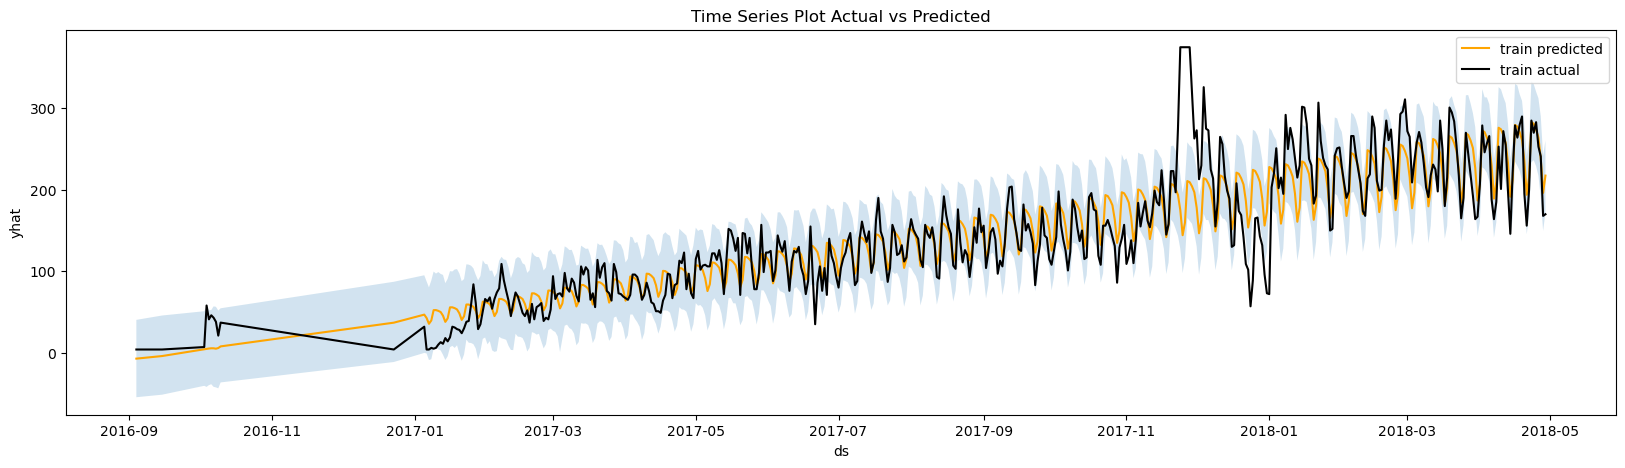

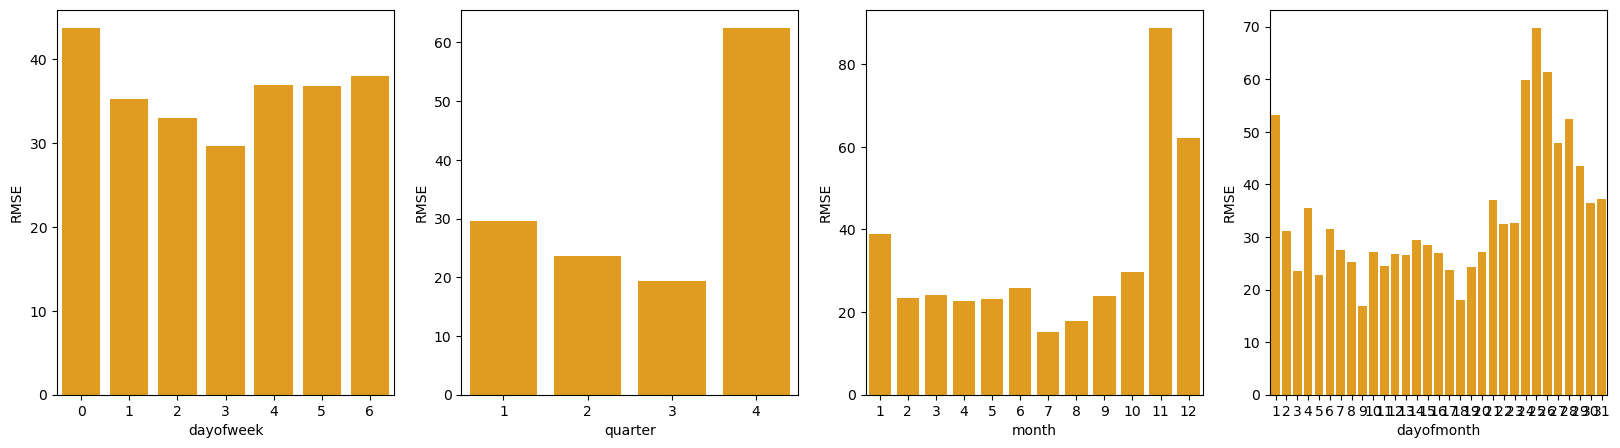

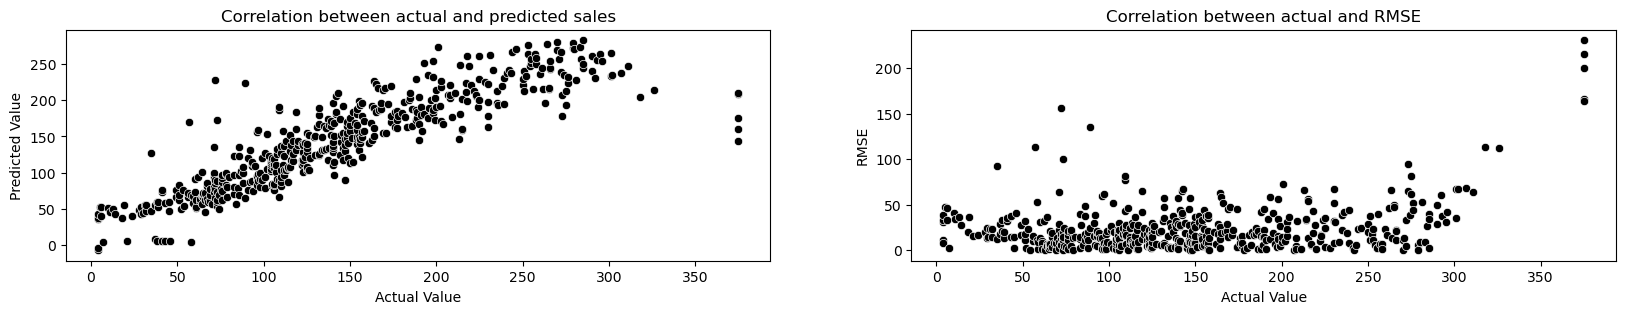

Test dataset evaluation
RMSE: 102.11866703541156


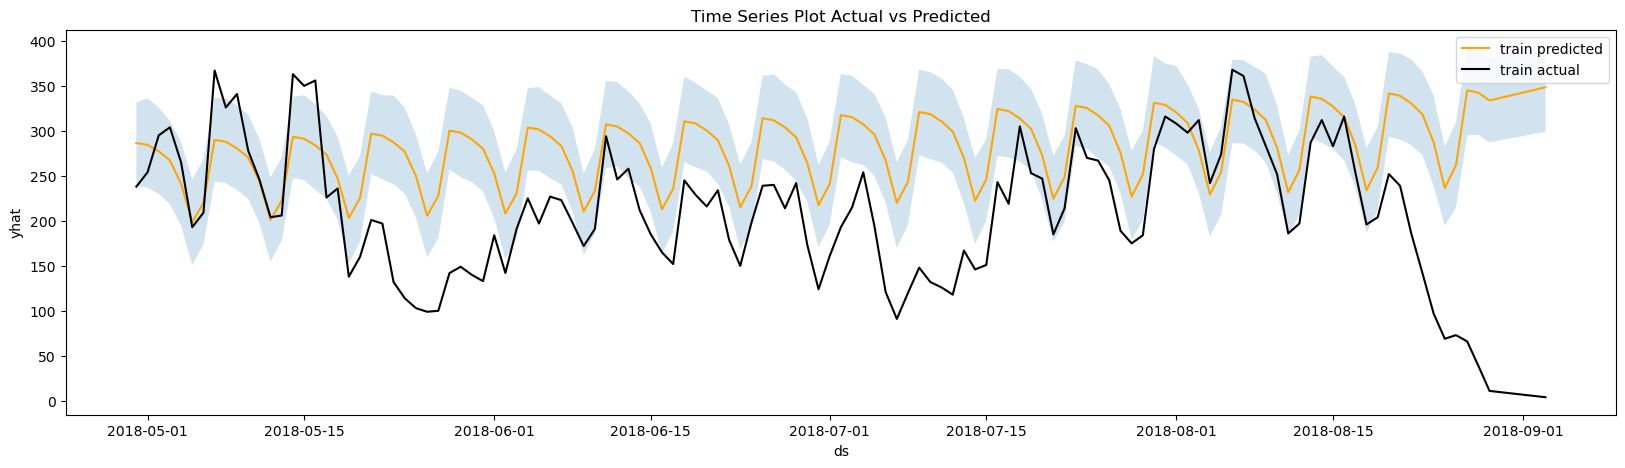

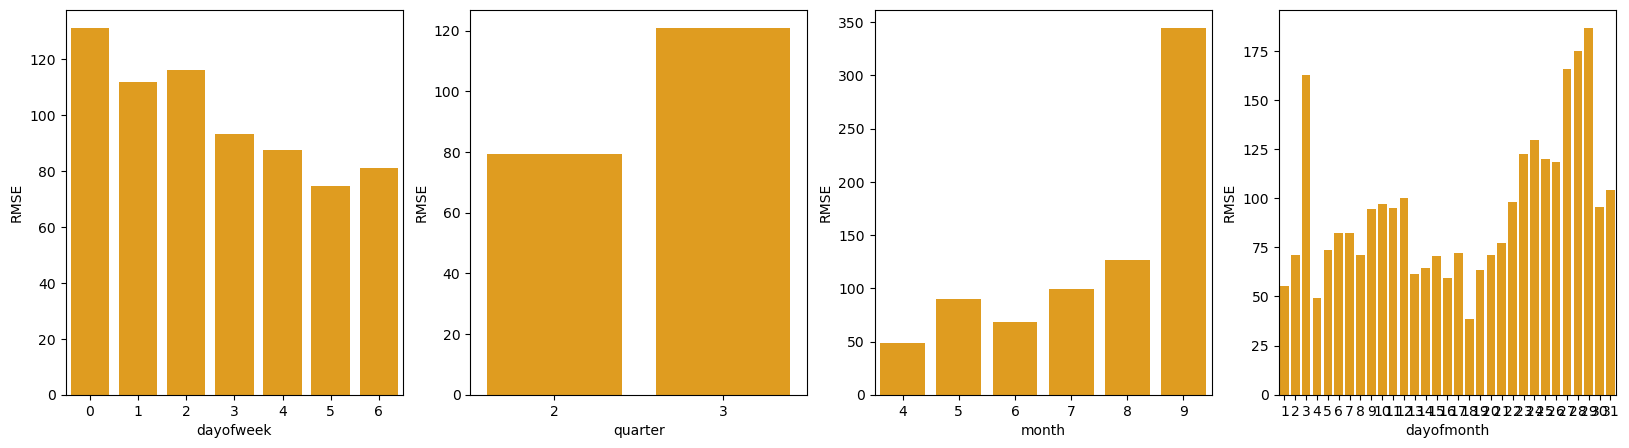

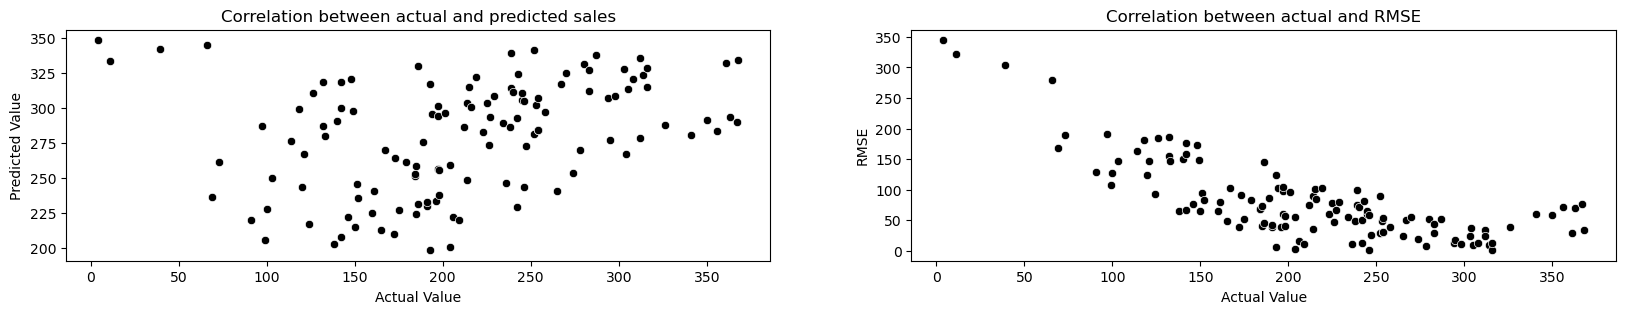

In [69]:
predict_eval(train, test, 'rmv_outliers', tuning=True)

## Including the holiday context

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}


23:38:59 - cmdstanpy - INFO - Chain [1] start processing
23:38:59 - cmdstanpy - INFO - Chain [1] done processing


Train dataset evaluation
RMSE: 18.890646963083398


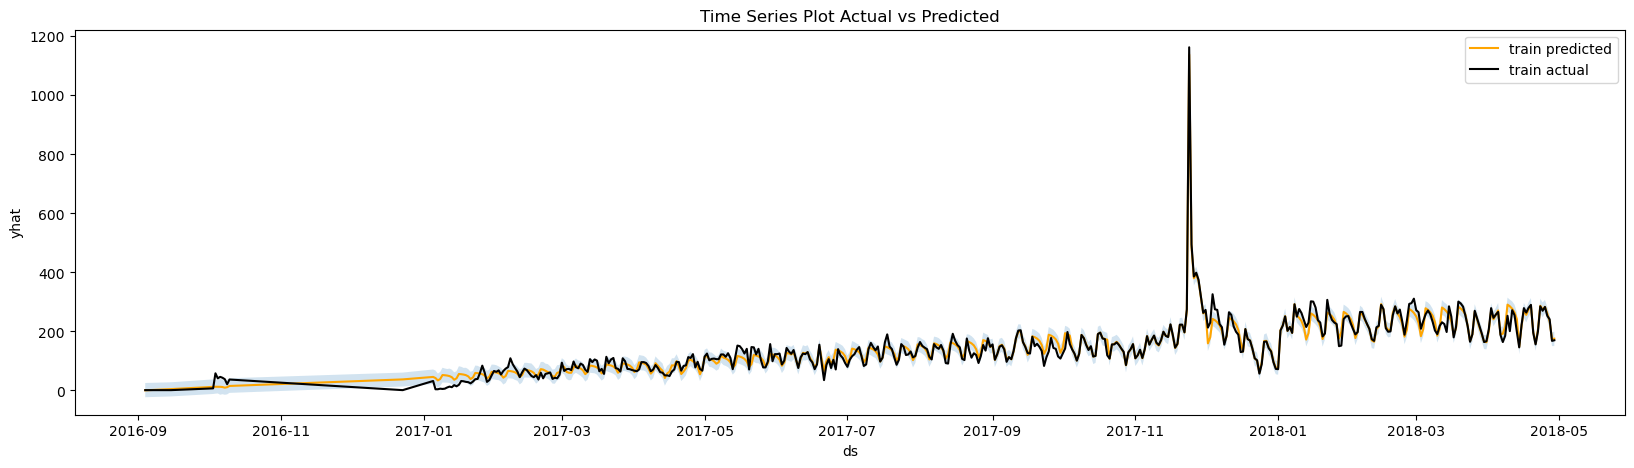

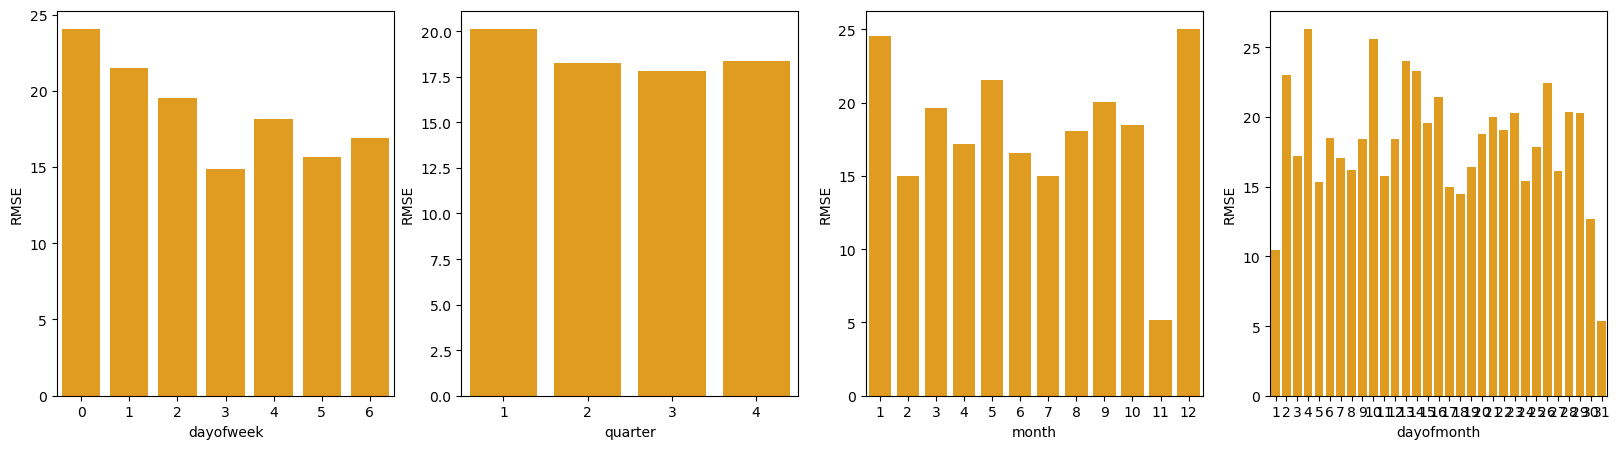

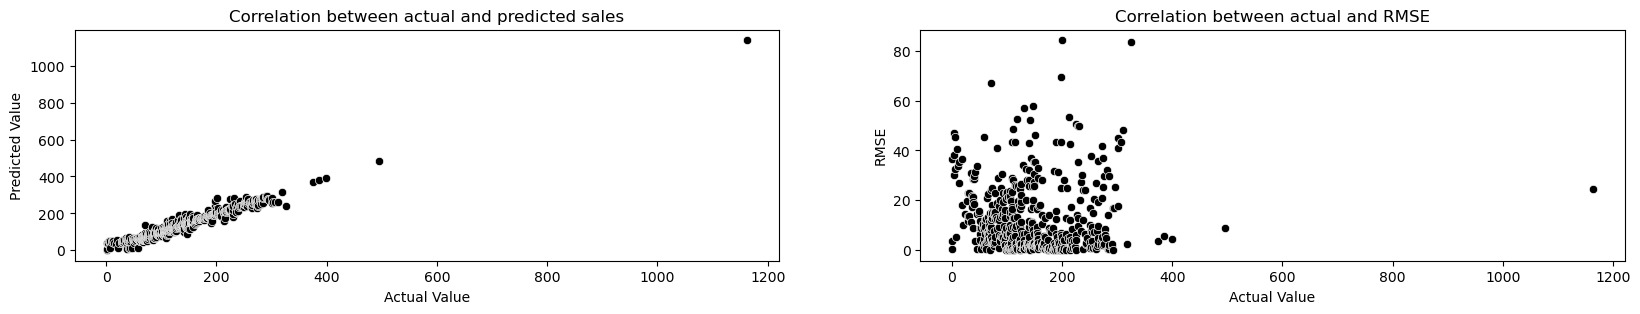

Test dataset evaluation
RMSE: 99.69471536618096


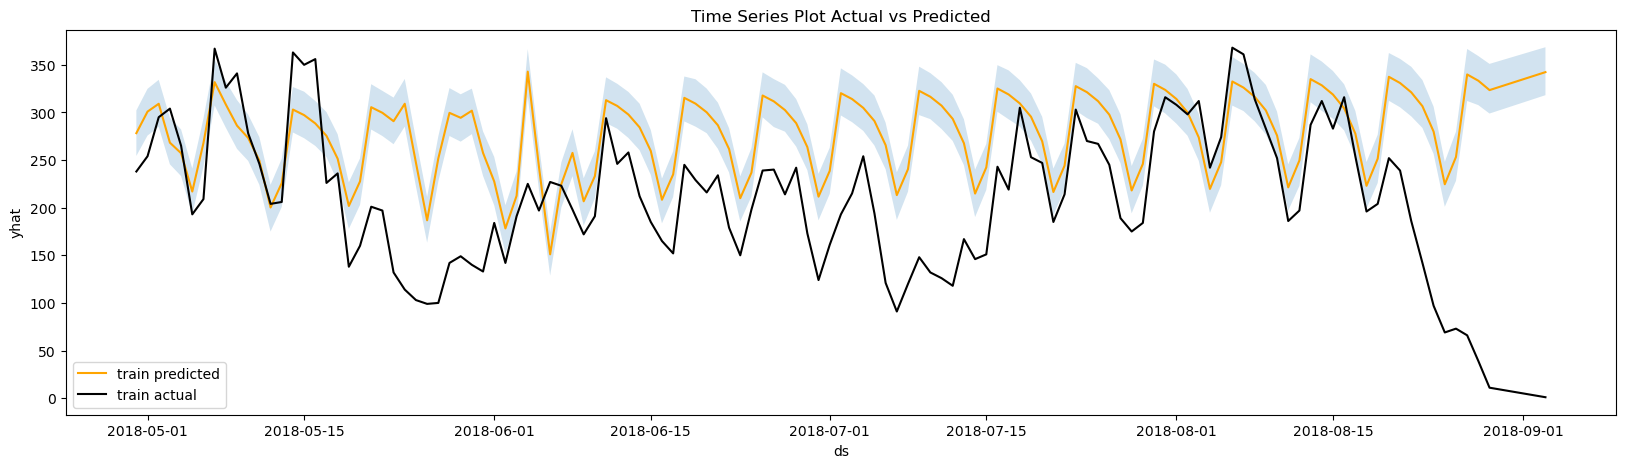

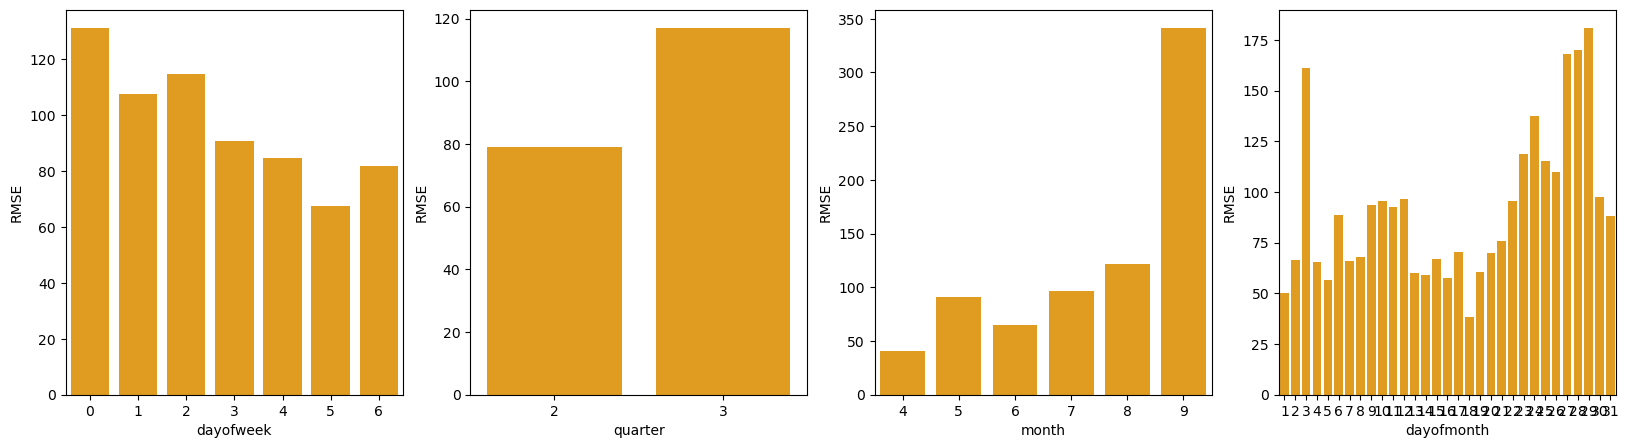

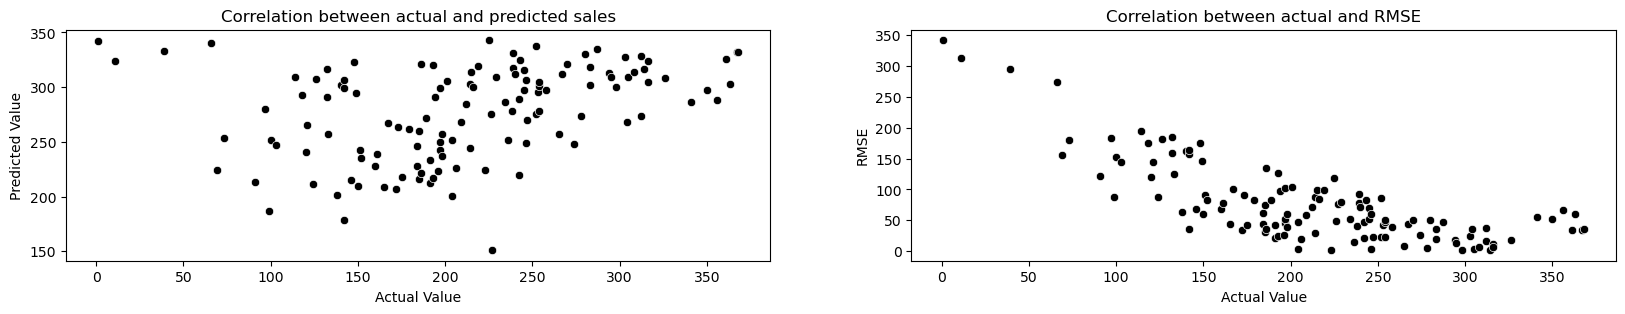

In [70]:
predict_eval(train, test, 'total_orders', tuning=True, holiday_context=True)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


23:41:57 - cmdstanpy - INFO - Chain [1] start processing
23:41:57 - cmdstanpy - INFO - Chain [1] done processing


Train dataset evaluation
RMSE: 19.212019993554204


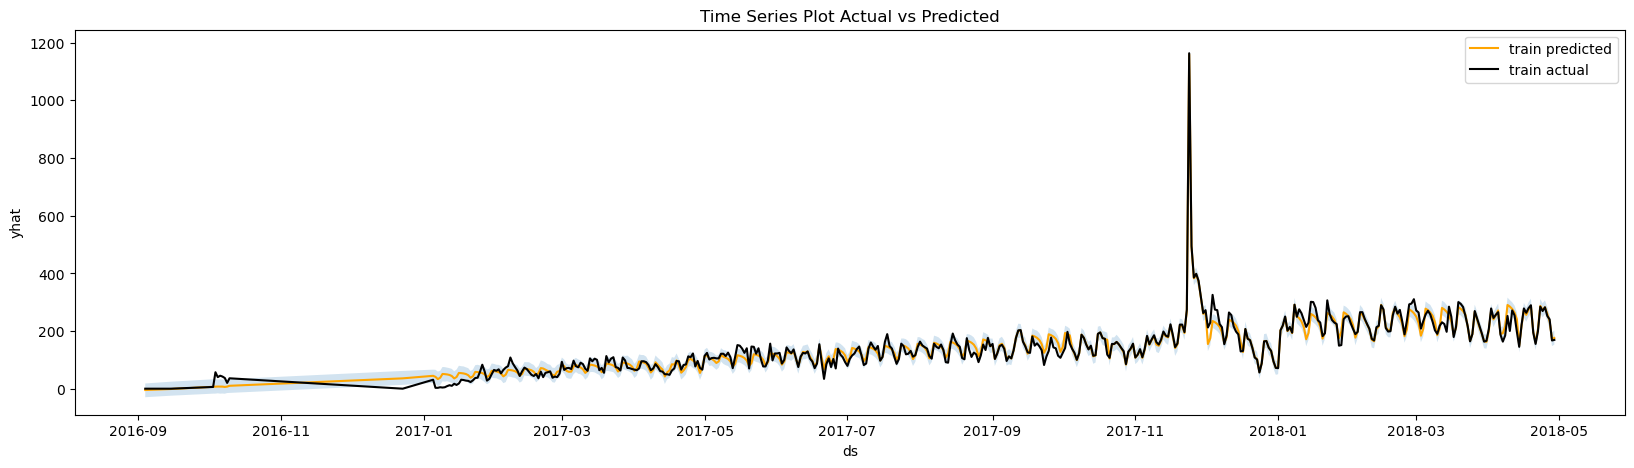

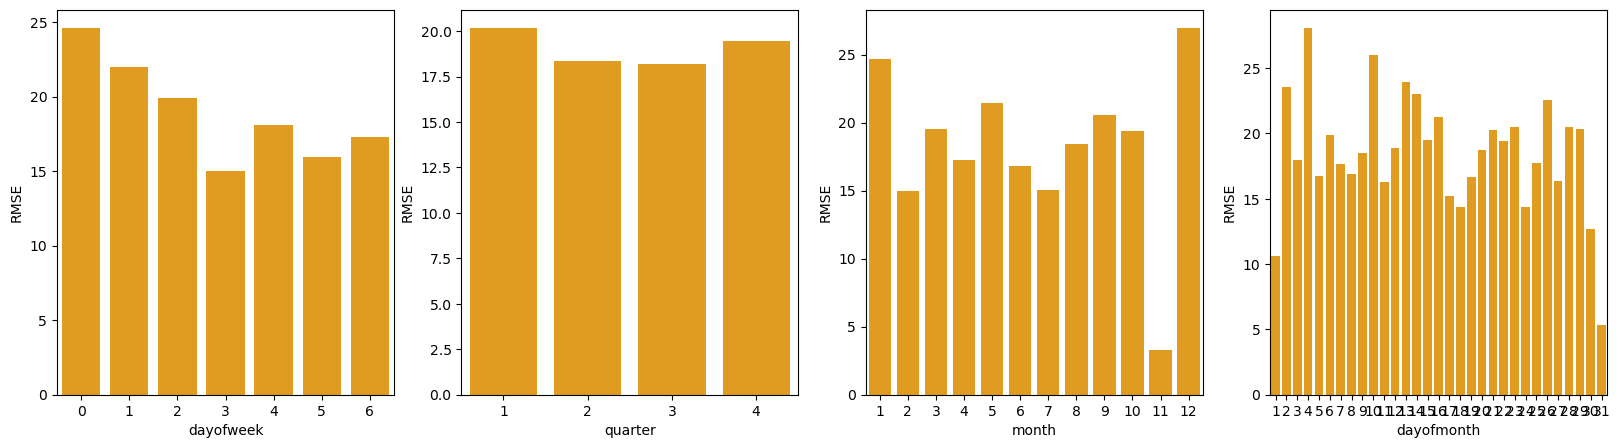

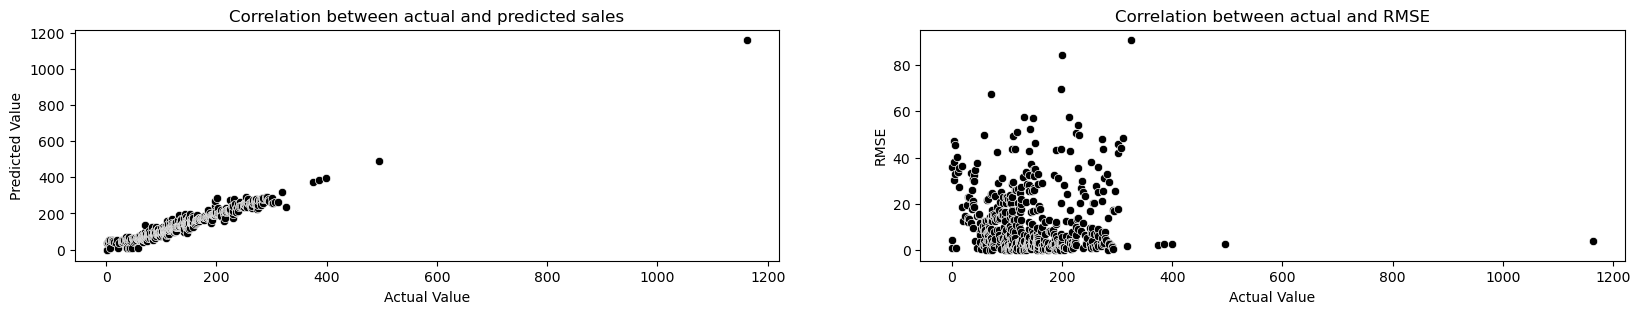

Test dataset evaluation
RMSE: 100.73402589259778


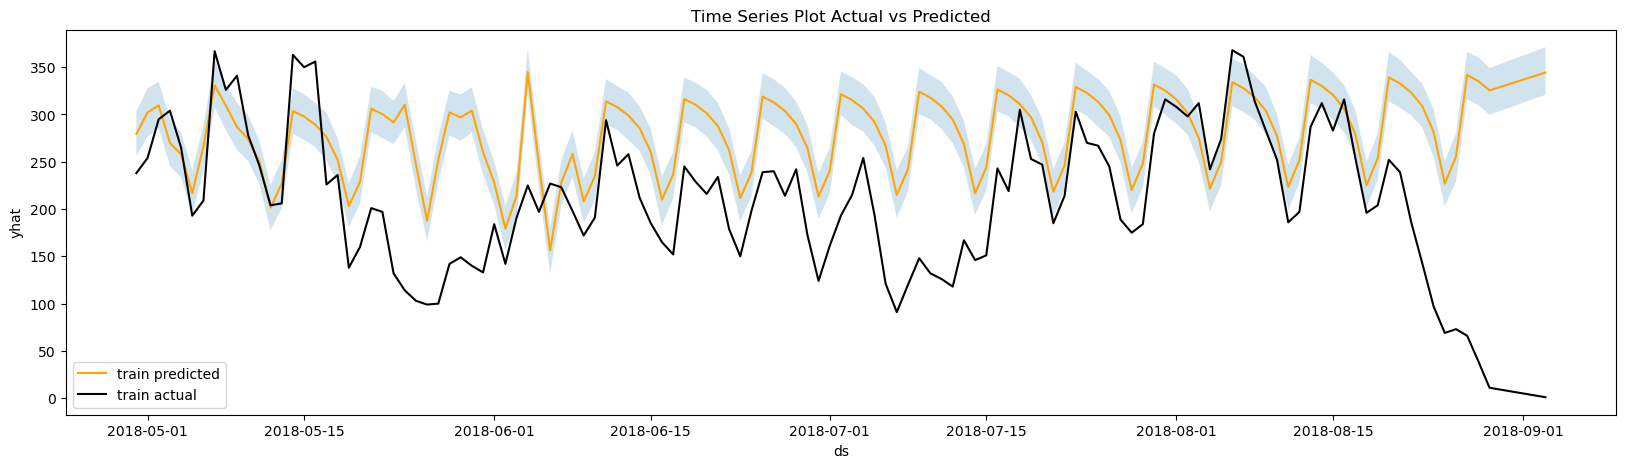

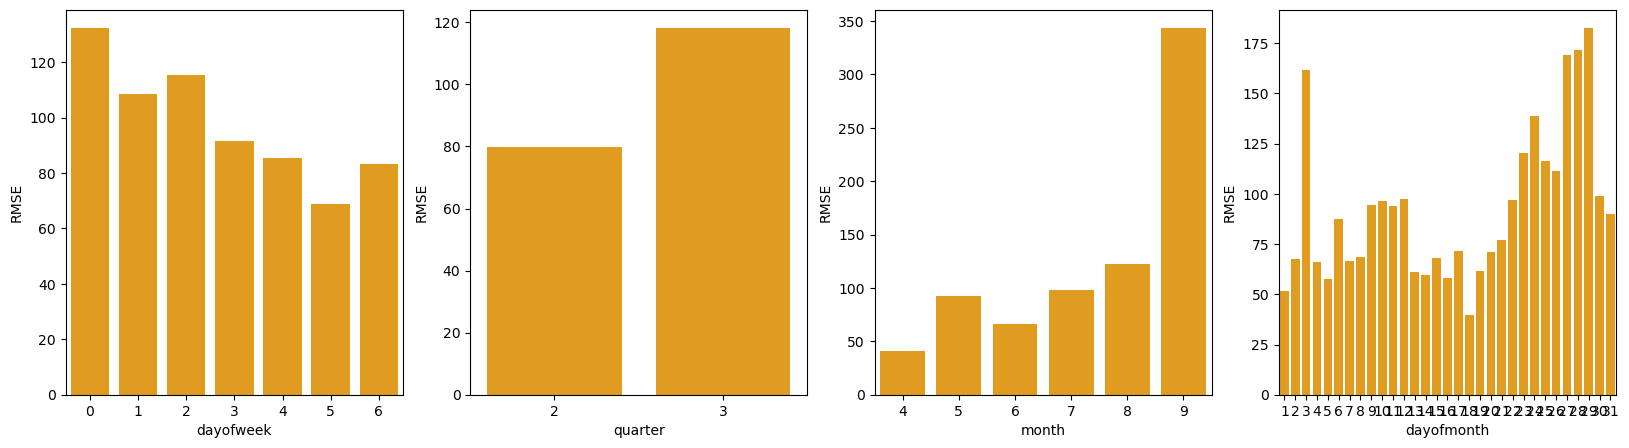

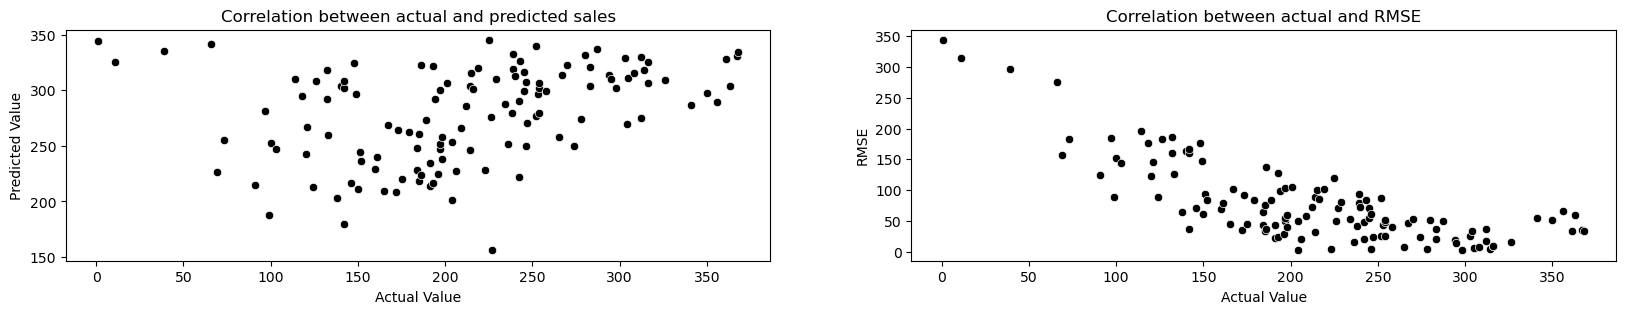

In [71]:
predict_eval(train, test, 'scaling', tuning=True, holiday_context=True)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


23:44:59 - cmdstanpy - INFO - Chain [1] start processing
23:45:00 - cmdstanpy - INFO - Chain [1] done processing


Train dataset evaluation
RMSE: 20.28110310215872


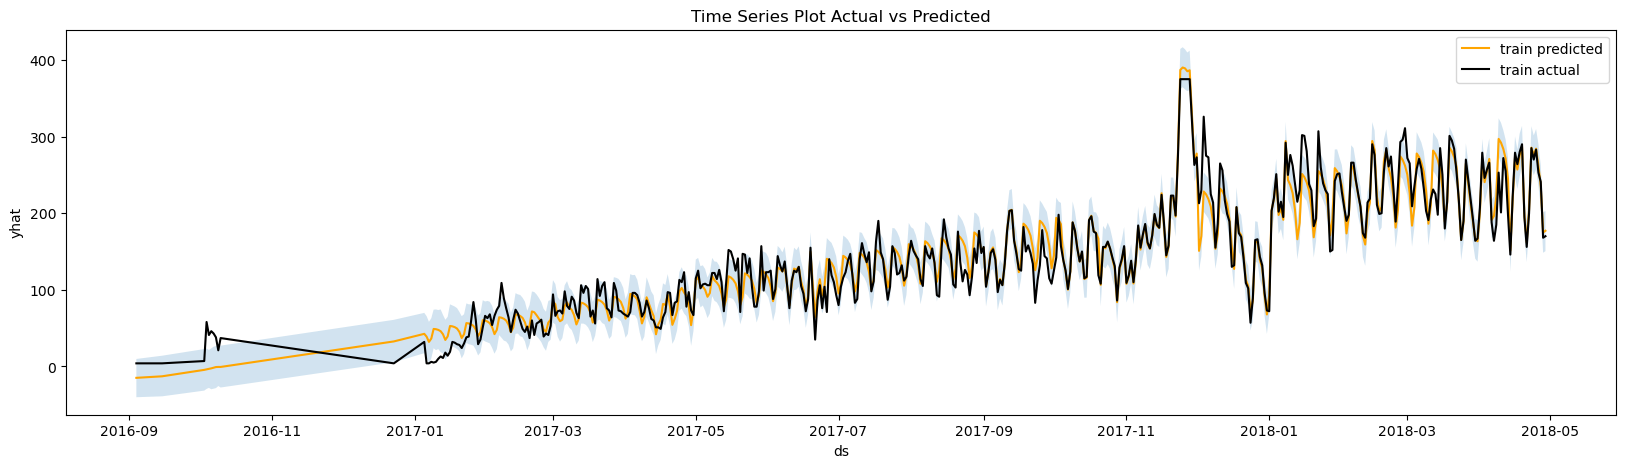

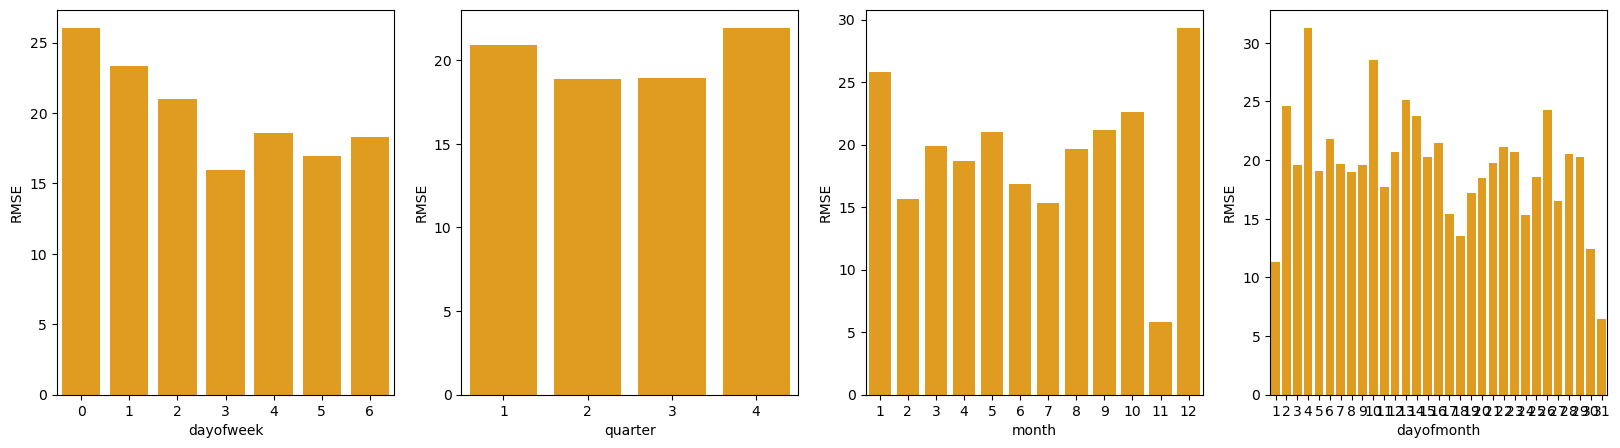

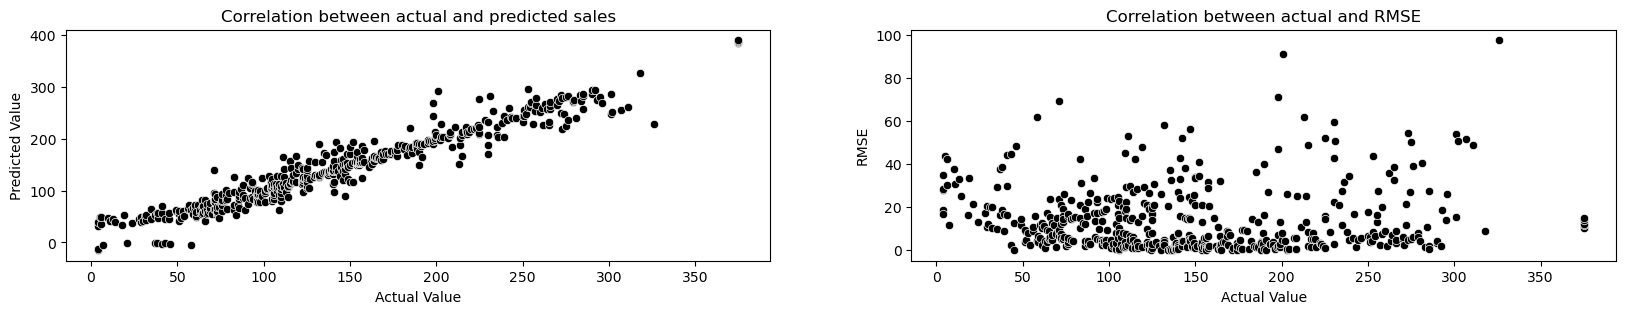

Test dataset evaluation
RMSE: 114.88524046249158


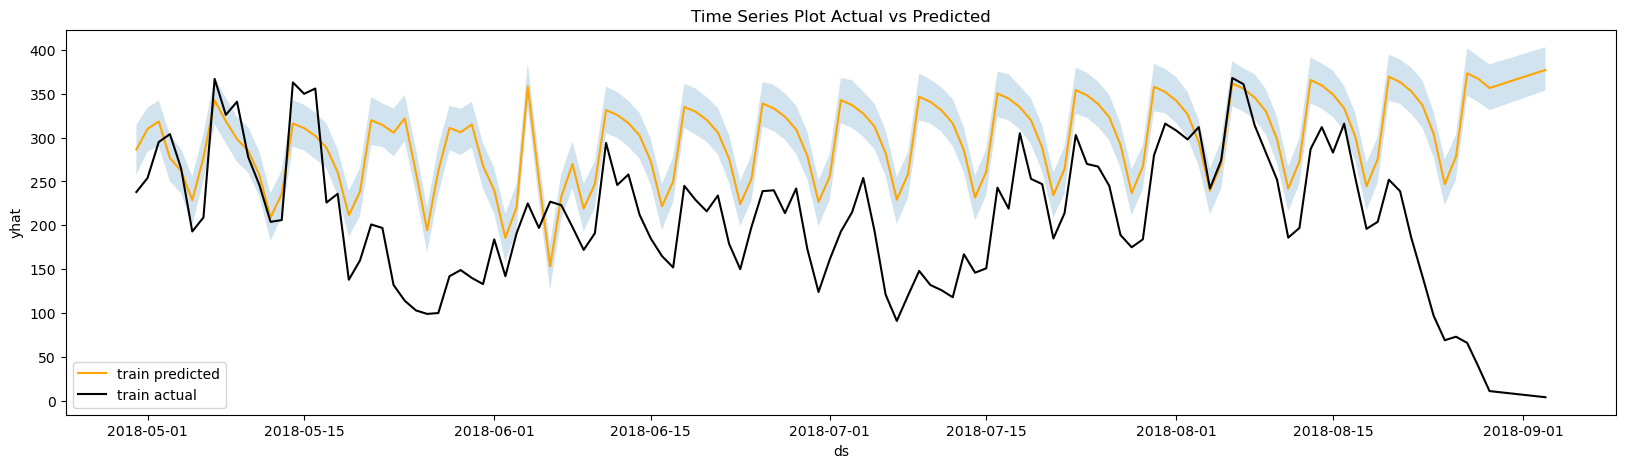

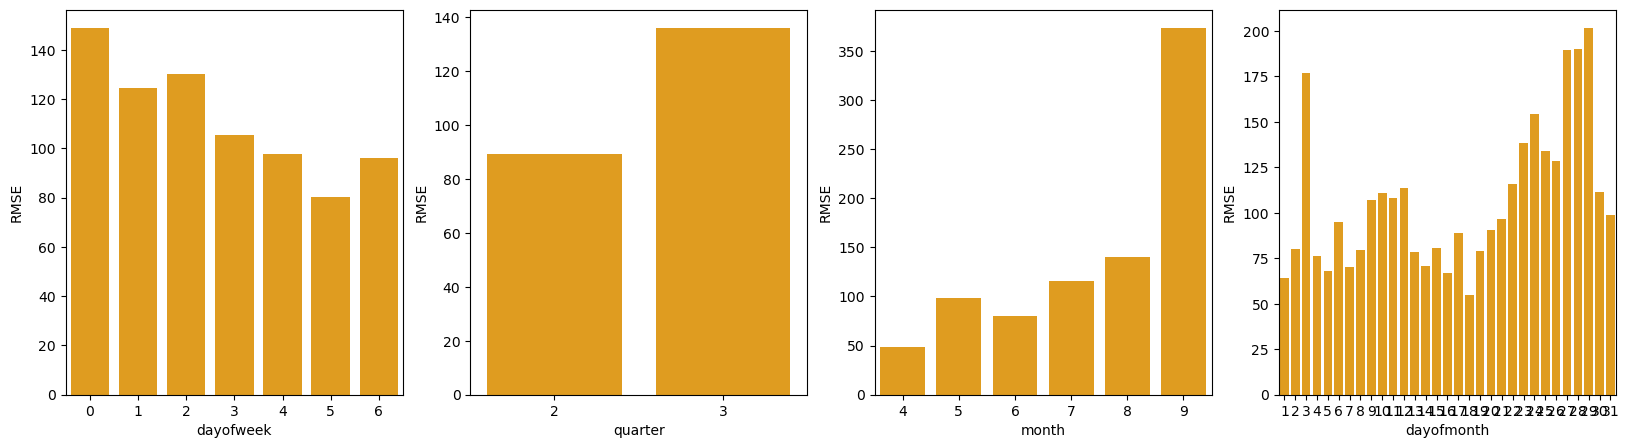

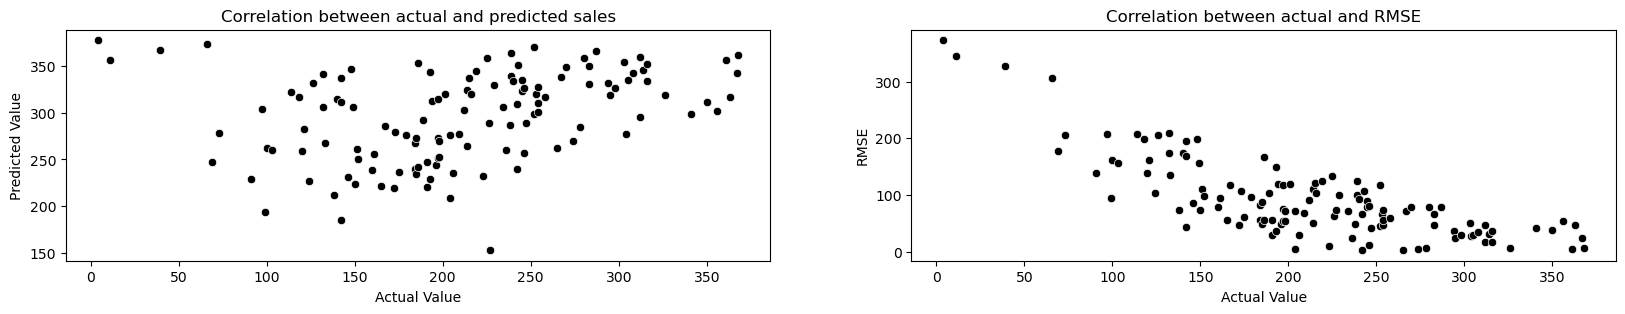

In [72]:
predict_eval(train, test, 'rmv_outliers', tuning=True, holiday_context=True)

#### By this means place where we used scalling + tuning+ context , we recieved the best output

#### Sentiment analysis using NLP techniques and LSTM

In [105]:
args = Namespace(
    dataset_csv =  r"olist_order_reviews_dataset.csv" ,
    train_split = 0.8,
    random_state = 42,
    vocab_size = 10000,
    embedding_dim = 16,
    max_length = 120,
    batch_size=128,
    num_epochs=5,
    early_stopping_criteria=2,
    dropout_p=0.3,
    model_storage="model_storage/lstm",
)


#### Loading the data again frrom the args variable that is Namespace contain our dataframe

In [106]:
def load_data(path, column_text='review_comment_message', column_score='review_score', points_cut = [0, 2, 5], classes = [0, 1]):
    df = pd.read_csv(path)
    df = df.dropna(subset=[column_text])

    df['label'] = pd.cut(df[column_score], bins=points_cut, labels=classes)

    df = df.rename(columns={column_text: 'text'})
    df = df[['text','label']]

    return df


df = load_data(args.dataset_csv)


In [107]:
def split_test_train(data, split_train=0.8, random_state=200):
    df_train = data.sample(frac = split_train, random_state = random_state)
    df_test = data.drop(df_train.index)

    training_sentences = []
    training_labels = []
    testing_sentences = []
    testing_labels = []
    for index, train in df_train.iterrows():
        training_sentences.append(str(train['text']))
        training_labels.append(train['label'])
    
    for index, test in df_test.iterrows():
        testing_sentences.append(str(test['text']))
        testing_labels.append(test['label'])
  
    training_labels_final = np.array(training_labels)
    testing_labels_final = np.array(testing_labels)

    return training_sentences, training_labels, testing_sentences, testing_labels


In [108]:
training_sentences, training_labels, testing_sentences, testing_labels = split_test_train(df, split_train=args.train_split, random_state=args.random_state)

In [109]:
#Function to preprocess using text_to_sequence_padding for both train and test

oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words = args.vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

def preprocess(training_sentences, testing_sentences, max_length, vocab_size, trunc_type='post', oov_tok = "<OOV>"):
    
    training_sentences = tokenizer.texts_to_sequences(training_sentences)
    training_padded = pad_sequences(training_sentences,maxlen=max_length, truncating=trunc_type)
    
    testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
    testing_padded = pad_sequences(testing_sequences,maxlen=max_length)
    return training_padded, testing_padded

In [110]:
training_sentences, testing_sentences = preprocess(training_sentences, testing_sentences, args.max_length, args.vocab_size)

In [111]:
def create_model():
    input = tf.keras.Input(shape=(args.max_length))
    x = tf.keras.layers.Embedding(args.vocab_size, args.embedding_dim, input_length=args.max_length)(input)

    x = tf.keras.layers.LSTM(16, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(16)(x)

    x = tf.keras.layers.Dropout(0.6)(x)

    x = tf.keras.layers.Dense(32, activation='relu')(x)

    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(input, output)

#### We are using earlyStoppingCallback also here and used other paremters 

In [112]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=args.early_stopping_criteria)

model = create_model()
model.compile(
  loss = tf.keras.losses.BinaryCrossentropy(),
  optimizer= tf.keras.optimizers.Adam(
    learning_rate=0.0001),
  metrics=['accuracy']
)

history = model.fit(
    training_sentences,
    np.array(training_labels), 
    validation_data=(testing_sentences, np.array(testing_labels)),
    epochs=15,
    batch_size=args.batch_size,
    callbacks= [earlyStoppingCallback],
)

Epoch 1/15
257/257 [==============================] - 32s 107ms/step - loss: 0.6107 - accuracy: 0.7317 - val_loss: 0.5373 - val_accuracy: 0.7411
Epoch 2/15
257/257 [==============================] - 27s 106ms/step - loss: 0.5074 - accuracy: 0.7379 - val_loss: 0.4649 - val_accuracy: 0.7746
Epoch 3/15
257/257 [==============================] - 28s 107ms/step - loss: 0.4413 - accuracy: 0.7909 - val_loss: 0.3932 - val_accuracy: 0.8222
Epoch 4/15
257/257 [==============================] - 27s 104ms/step - loss: 0.3660 - accuracy: 0.8422 - val_loss: 0.3364 - val_accuracy: 0.8455
Epoch 5/15
257/257 [==============================] - 27s 106ms/step - loss: 0.3241 - accuracy: 0.8668 - val_loss: 0.3140 - val_accuracy: 0.8587
Epoch 6/15
257/257 [==============================] - 26s 102ms/step - loss: 0.2990 - accuracy: 0.8774 - val_loss: 0.3015 - val_accuracy: 0.8666
Epoch 7/15
257/257 [==============================] - 27s 104ms/step - loss: 0.2854 - accuracy: 0.8853 - val_loss: 0.2942 - val_ac

#### Now we can see the accuracy for the test set

In [113]:
model.evaluate(testing_sentences, np.array(testing_labels))

257/257 [==============================] - 7s 26ms/step - loss: 0.2815 - accuracy: 0.8881


[0.2815360724925995, 0.8881024718284607]

#### Figure to draw the Accuracy and val Accuracy

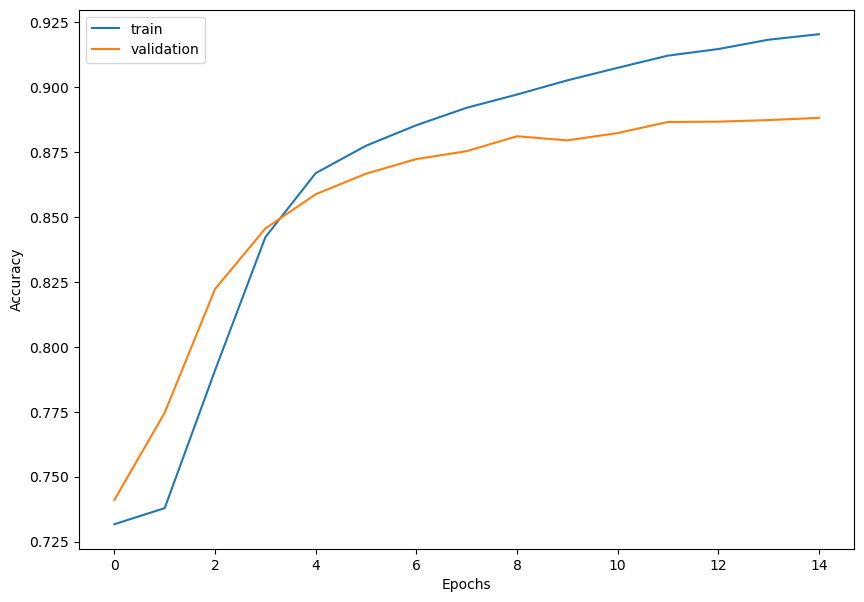

In [114]:
plt.figure(figsize = (10,7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### Figure to draw the loss and val loss

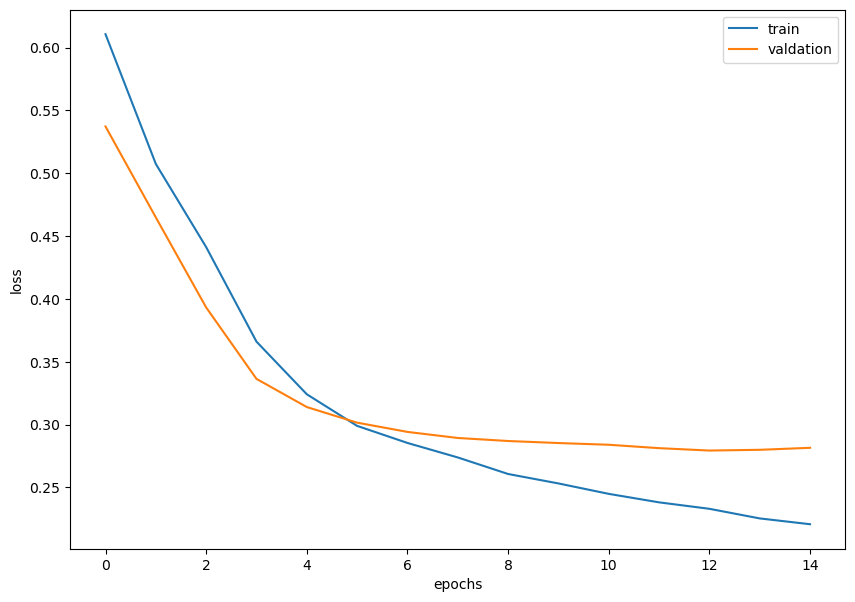

In [115]:
plt.figure(figsize = (10,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'valdation'], loc='upper right')
plt.show()
